# Produisez une étude de marché
**Scénario**
# Mission 1: Construisez l'échantillon contenant l'ensemble des pays disponibles.
   1. La population par pays
   2. Données sur les bilans alimentaires mondiaux (2019)
   3. Les valeurs de PIB par habitant,
   4. Production viande de Volailles, taux d'autosuffisanc
   5. Dataframe principal   
# Mission 2 : réalisation d'un dendrogramme
1. Environnement
2. Aperçu des corrélations
3. Classification des pays via Clustering Hiérarchique Ascendant (CHA)
4. Attribution des 5 groupes et World map de répartition
5. Centroïdes des clusters
6. Description et critique des clusters

# Mission 3 : Analyse en Composantes Principales (ACP)
1. Application de l'algorithme du K-Means
2. Visualisation des clusters en ACP pour la projection des données
3. ACP - Cercle des corrélations¶
4. Sélections des pays sur groupes Kmeans.
# Mission 4 : Tests statistiques
3. Test d'adéquation de Kolmogorov-Smirno
2. Tester l'égalité de la variance
   



# Scénario
Votre entreprise **d'agroalimentaire** souhaite se développer à l'international. Elle est spécialisée dans...
 le poulet !

L'international, oui, mais pour l'instant, le champ des possibles est bien large : aucun pays particulier ni aucun continent n'est pour le moment choisi. Tous les pays sont envisageables !

Votre objectif sera d'aider **à cibler plus particulièrement certains pays**, dans le but d'approfondir ensuite l'étude de marché. Plus particulièrement, l'idéal serait de produire des "groupes" de pays, plus ou moins gros, dont on connaît les caractéristiques.

Dans un premier temps, la stratégie est plutôt d'exporter les produits plutôt que de produire sur place, c'est-à-dire dans le(s) nouveau(x) pays ciblé(s).


Pour identifier les pays propices à une insertion dans le marché du poulet,
 Il vous a été demandé de cibler les pays. 
 Etudier les régimes alimentaires de chaque pays, notamment en termes de protéines d'origine animale et en termes de calories.


Construisez votre échantillon contenant l'ensemble des pays disponibles, chacun caractérisé par ces variables :

différence de population entre une année antérieure (au choix) et l'année courante, exprimée en pourcentage ;
proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays ;
disponibilité alimentaire en protéines par habitant ;
disponibilité alimentaire en calories par habitant.

Construisez un dendrogramme contenant l'ensemble des pays étudiés, puis coupez-le afin d'obtenir 5 groupes.

Caractérisez chacun de ces groupes selon les variables cités précédemment, et facultativement selon d'autres variables que vous jugerez pertinentes (ex : le PIB par habitant). Vous pouvez le faire en calculant la position des centroïdes de chacun des groupes, puis en les commentant et en les critiquant au vu de vos objectifs.

Donnez une courte liste de pays à cibler, en présentant leurs caractéristiques. Un découpage plus précis qu'en 5 groupes peut si besoin être effectué pour cibler un nombre raisonnable de pays. 

Visualisez vos  partitions dans le premier plan factoriel obtenu par ACP.

Dans votre partition, vous avez obtenu des groupes distincts. Vérifiez donc qu'ils diffèrent réellement. Pour cela, réalisez les tests statistiques suivants :

un test d'adéquation : parmi les 4 variables, ou parmi d'autres variables que vous trouverez pertinentes, trouvez une variable dont la loi est normale ;
un test de comparaison de deux populations (dans le cas gaussien) : choisissez 2 clusters parmi ceux que vous aurez déterminé. Sur ces 2 clusters, testez la variable gaussienne grâce à un test de comparaison.

In [1]:
# Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn as sk
import scipy as sp
import pca as pca
from sklearn import cluster
from sklearn.cluster import KMeans



In [2]:
#Versions utilisées
print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Seaborn : " + str(sns.__version__))

# Styles Seaborn
sns.set( 
    style='whitegrid',
    context='notebook',
    palette='Paired',
    rc={'figure.figsize':(8,5)})

Jupyter Notebook : 1.2.4
Pandas : 1.2.4
Numpy : 1.20.1
Seaborn : 0.11.1


# Mission 1:  Construisez l'échantillon contenant l'ensemble des pays disponibles.


## 1. La population par pays
la variation de la population entre 2009 et 2019, en %, qui sera positive en cas de croissance ou négative en cas de baisse démographique ;

Sources FAO (https://www.fao.org/faostat/fr/#data/OA)

In [3]:
df_population = pd.read_csv('datas/fao-populations_2019- 2009.csv' , header=0, sep=",", decimal=".")
df_population.head(2)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2009,2009,1000 personnes,28394.813,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2019,2019,1000 personnes,38041.754,X,Sources internationales sûres,NaN


In [4]:
df_population = df_population[['Code zone (FAO)', 'Zone', 'Année', 'Valeur']]
df_population['Valeur'] = df_population['Valeur']*1000
#pivot
df_population = df_population.pivot_table(index=['Code zone (FAO)','Zone'], columns='Année', values = 'Valeur', aggfunc = sum).reset_index()
#rename
df_population.columns = ['Code zone (FAO)','Zone', '2009', '2019']

#variable creation
df_population['Évolution population (%)'] = round((df_population['2019'] - df_population['2009']) /
                                               df_population['2019'] *100,2)

df_population= df_population.rename(columns= {'2019': 'population',})
df_population= df_population[[ 'Code zone (FAO)','Zone'  ,'population' ,'Évolution population (%)']]

#show

df_population.head(2)

,Code zone (FAO),Zone,population,Évolution population (%)
0,1,Arménie,2957731.0,2.35
1,2,Afghanistan,38041754.0,25.36


## 2. Données sur les bilans alimentaires mondiaux (2019)



Sources FAO (http://www.fao.org/faostat/fr/#data)


In [5]:
df_dispo_alimentaire = pd.read_csv('datas/les bilans alimentaires 2019 2.csv', header=0, sep=",", decimal=".")
#Il y a un problème avec le site Web de la FAO traitant de la langue française lors du téléchargement du fichier
df_dispo_alimentaire.head(3)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code ?l?ment,?l?ment,Code Produit,Produit,Code ann?e,Ann?e,Unit?,Valeur,Symbole,Description du Symbole
0,FBS,Bilans Alimentaires (2010-),2,Afghanistan,664,Disponibilit? alimentaire (Kcal/personne/jour),2901,Total General,2019,2019,Kcal/personne/jour,2273.00,Fc,Donn?e calcul?e
1,FBS,Bilans Alimentaires (2010-),2,Afghanistan,674,Disponibilit? de prot?ines en quantit? (g/pers...,2901,Total General,2019,2019,g/personne/jour,57.31,Fc,Donn?e calcul?e
2,FBS,Bilans Alimentaires (2010-),2,Afghanistan,664,Disponibilit? alimentaire (Kcal/personne/jour),2941,Produits Animaux,2019,2019,Kcal/personne/jour,187.00,Fc,Donn?e calcul?e


In [6]:
df_dispo_alimentaire = df_dispo_alimentaire.pivot_table(index=[ 'Zone','Code zone (FAO)'],
                                columns=['?l?ment', 'Produit'],
                                values = 'Valeur',
                                aggfunc=sum).reset_index()
df_dispo_alimentaire.head()

?l?ment                   Zone Code zone (FAO)  \
Produit                                          
0                       ?gypte              59   
1                 ?les Salomon              25   
2          ?mirats arabes unis             225   
3                     ?quateur              58   
4        ?tats-Unis d'Am?rique             231   

?l?ment Disponibilit? alimentaire (Kcal/personne/jour)                \
Produit                               Produits Animaux Total General   
0                                                267.0        3307.0   
1                                                202.0        2411.0   
2                                                512.0        3084.0   
3                                                570.0        2563.0   
4                                               1126.0        3862.0   

?l?ment Disponibilit? de prot?ines en quantit? (g/personne/jour)                
Produit                                         Produits Animaux Total General  
0                                                    23.68               95.52  
1                                                    15.82               52.85  
2                                                    35.71               80.43  
3                                                    32.68               64.09  
4                                                    75.93              115.01

In [7]:
df_dispo_alimentaire["ratio_proteines_animales(%)"] = round((df_dispo_alimentaire[('Disponibilit? de prot?ines en quantit? (g/personne/jour)', 'Produits Animaux')]
                                                                         /df_dispo_alimentaire[('Disponibilit? de prot?ines en quantit? (g/personne/jour)', 'Total General')])*100,2)
df_dispo_alimentaire.head(2)

?l?ment          Zone Code zone (FAO)  \
Produit                                 
0              ?gypte              59   
1        ?les Salomon              25   

?l?ment Disponibilit? alimentaire (Kcal/personne/jour)                \
Produit                               Produits Animaux Total General   
0                                                267.0        3307.0   
1                                                202.0        2411.0   

?l?ment Disponibilit? de prot?ines en quantit? (g/personne/jour)  \
Produit                                         Produits Animaux   
0                                                    23.68         
1                                                    15.82         

?l?ment               ratio_proteines_animales(%)  
Produit Total General                              
0               95.52                       24.79  
1               52.85                       29.93

In [8]:
df= pd.merge(df_population, df_dispo_alimentaire, on="Code zone (FAO)")

df.head()

/Users/rowaidakanaan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/Users/rowaidakanaan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Code zone (FAO),Zone,population,Évolution population (%),"(Zone, )","(Disponibilit? alimentaire (Kcal/personne/jour), Produits Animaux)","(Disponibilit? alimentaire (Kcal/personne/jour), Total General)","(Disponibilit? de prot?ines en quantit? (g/personne/jour), Produits Animaux)","(Disponibilit? de prot?ines en quantit? (g/personne/jour), Total General)","(ratio_proteines_animales(%), )"
0,1,Arménie,2957731.0,2.35,Arm?nie,975.0,3022.0,52.86,94.29,56.06
1,2,Afghanistan,38041754.0,25.36,Afghanistan,187.0,2273.0,10.34,57.31,18.04
2,3,Albanie,2880917.0,-3.20,Albanie,1021.0,3338.0,62.47,116.02,53.84
3,4,Algérie,43053054.0,17.93,Alg?rie,379.0,3493.0,24.09,90.84,26.52
4,7,Angola,31825295.0,29.26,Angola,211.0,2445.0,15.54,52.09,29.83


In [9]:
df = df[['Code zone (FAO)','Zone', 'population','Évolution population (%)',
         ('Disponibilit? alimentaire (Kcal/personne/jour)', 'Total General'),
         ('Disponibilit? de prot?ines en quantit? (g/personne/jour)', 'Total General'),
         ('ratio_proteines_animales(%)','') ]]
df.head()

/Users/rowaidakanaan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,Code zone (FAO),Zone,population,Évolution population (%),"(Disponibilit? alimentaire (Kcal/personne/jour), Total General)","(Disponibilit? de prot?ines en quantit? (g/personne/jour), Total General)","(ratio_proteines_animales(%), )"
0,1,Arménie,2957731.0,2.35,3022.0,94.29,56.06
1,2,Afghanistan,38041754.0,25.36,2273.0,57.31,18.04
2,3,Albanie,2880917.0,-3.20,3338.0,116.02,53.84
3,4,Algérie,43053054.0,17.93,3493.0,90.84,26.52
4,7,Angola,31825295.0,29.26,2445.0,52.09,29.83


In [10]:
df.rename(columns={('Disponibilit? alimentaire (Kcal/personne/jour)', 'Total General'):'dispo_calories',
                              ('Disponibilit? de prot?ines en quantit? (g/personne/jour)', 'Total General'):'dispo_proteines',
                            ('ratio_proteines_animales(%)','' ):'ratio_prot_anim'}
                     ,inplace=True)

df['dispo_calories'] = df['dispo_calories']*365
df['dispo_proteines'] = df['dispo_proteines']*365
df.head()

,Code zone (FAO),Zone,population,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim
0,1,Arménie,2957731.0,2.35,1103030.0,34415.85,56.06
1,2,Afghanistan,38041754.0,25.36,829645.0,20918.15,18.04
2,3,Albanie,2880917.0,-3.20,1218370.0,42347.30,53.84
3,4,Algérie,43053054.0,17.93,1274945.0,33156.60,26.52
4,7,Angola,31825295.0,29.26,892425.0,19012.85,29.83


## 3.  Les valeurs de PIB par habitant,
https://www.fao.org/faostat/fr/#data/FS

In [11]:
# Dataframes des données complémentaires
# Indicateurs Macro (PIB et croissance)
df_PIB_habitant = pd.read_csv('datas/PIB.csv', header=0, sep=',', decimal='.')

df_PIB_habitant.head(2)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,MK,Indicateurs macro,2,Afghanistan,6110,Valeur US $,22008,Produit Intérieur Brut,2019,2019,millions,17876.546427,X,Sources internationales sûres,NaN
1,MK,Indicateurs macro,2,Afghanistan,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2019,2019,US$,469.919090,X,Sources internationales sûres,NaN


In [12]:
df_PIB_habitant = df_PIB_habitant[['Code zone (FAO)','Élément','Valeur','Produit']]
                        

df_PIB_habitant = df_PIB_habitant.pivot_table(index=['Code zone (FAO)'], columns='Élément', values='Valeur', aggfunc=sum).reset_index()
df_PIB_habitant = df_PIB_habitant.rename(columns={'Valeur US $ par habitant':"PIB_par_habitant" })
df_PIB_habitant = df_PIB_habitant[['Code zone (FAO)','PIB_par_habitant']]

df_PIB_habitant.head(2)

Élément,Code zone (FAO),PIB_par_habitant
0,1,4622.733216
1,2,469.919090


## 4. Production viande de Volailles, taux d'autosuffisance
défini en économie comme le rapport entre les importations et la disponibilité intérieure du pays ;

https://www.fao.org/faostat/fr/#data/FBS

In [13]:
df_viande_volailles = pd.read_csv('datas/la viande de volailles1!.csv', header=0, sep=",", decimal=".")
df_viande_volailles.head(2)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Bilans Alimentaires (2010-),2,Afghanistan,5511,Production,2734,Viande de Volailles,2019,2019,Milliers de tonnes,28,Im,Données de la FAO basées sur une méthodologie ...
1,FBS,Bilans Alimentaires (2010-),2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2019,2019,Milliers de tonnes,44,Im,Données de la FAO basées sur une méthodologie ...


In [14]:
df_viande_volailles = df_viande_volailles.pivot_table(index=['Code zone (FAO)'],
                                columns=['Élément'],
                                values = 'Valeur',
                                aggfunc=sum).reset_index()
#Le taux_suffisance= Production  ÷ (Production alimentaire domestique + importations ー exportations) ×100
df_viande_volailles['taux_suffisance']=((df_viande_volailles['Production'] ) / 
                                           (df_viande_volailles['Disponibilité intérieure']))*100



#le taux de dépendance aux importations, défini en économie comme le rapport entre les importations et la disponibilité intérieure du pays ;

df_viande_volailles['dep_import']=(df_viande_volailles['Importations - Quantité'] /
                                                        df_viande_volailles['Disponibilité intérieure'])*100


#Le taux d'auto-suffisance alimentaire est un indice permettant de mesurer l'importance de la production alimentaire d'un pays par rapport à sa consommation intérieure.
df_viande_volailles = df_viande_volailles[['Code zone (FAO)','taux_suffisance','dep_import']]

df_viande_volailles.head(2)

Élément,Code zone (FAO),taux_suffisance,dep_import
0,1,21.818182,78.181818
1,2,41.791045,65.671642


**Le taux d'auto-suffisance alimentaire** est un indice permettant de mesurer l'importance de la production alimentaire d'un pays par rapport à sa consommation intérieure.




# Dataframe principal

In [15]:
df= pd.merge(df, df_PIB_habitant, on="Code zone (FAO)")


df= pd.merge(df, df_viande_volailles, on="Code zone (FAO)")
df.head(2)

,Code zone (FAO),Zone,population,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import
0,1,Arménie,2957731.0,2.35,1103030.0,34415.85,56.06,4622.733216,21.818182,78.181818
1,2,Afghanistan,38041754.0,25.36,829645.0,20918.15,18.04,469.919090,41.791045,65.671642


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Code zone (FAO)           178 non-null    int64  
 1   Zone                      178 non-null    object 
 2   population                178 non-null    float64
 3   Évolution population (%)  177 non-null    float64
 4   dispo_calories            178 non-null    float64
 5   dispo_proteines           178 non-null    float64
 6   ratio_prot_anim           178 non-null    float64
 7   PIB_par_habitant          178 non-null    float64
 8   taux_suffisance           176 non-null    float64
 9   dep_import                177 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 15.3+ KB


In [17]:
#Trouver les valeurs manquantes
df_null=  df.loc[df.isnull().any(axis=1)]
df_null

,Code zone (FAO),Zone,population,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import
48,72,Djibouti,973560.0,14.97,1020175.0,24064.45,19.73,3252.320409,NaN,100.000000
96,132,Maldives,530953.0,33.44,807380.0,29203.65,61.43,10626.484440,NaN,91.666667
165,236,Venezuela (République bolivarienne du),28515829.0,1.70,804460.0,18815.75,43.71,4732.820093,100.000000,NaN
176,276,Soudan,42813238.0,NaN,942065.0,27692.55,26.26,815.060101,133.928571,0.000000


In [18]:
df=df.dropna()


In [19]:
df.describe()

,Code zone (FAO),population,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import
count,174.000000,1.740000e+02,174.000000,1.740000e+02,174.000000,174.000000,174.000000,174.000000,174.000000
mean,126.879310,5.178110e+07,11.746839,1.055563e+06,29835.519540,42.672299,14222.029823,74.842751,42.160844
std,74.522234,1.884467e+08,10.457979,1.664980e+05,7658.403852,16.009148,19850.923947,45.443738,42.307453
min,1.000000,5.282300e+04,-24.230000,6.230550e+05,9457.150000,5.930000,260.381563,0.000000,0.000000
25%,63.750000,2.897758e+06,4.870000,9.422475e+05,23844.537500,29.182500,1863.037073,33.823529,4.304511
50%,121.500000,9.758323e+06,11.000000,1.051748e+06,29877.075000,44.220000,6100.852861,87.148533,26.789000
75%,188.750000,3.191866e+07,19.382500,1.201854e+06,35398.612500,56.010000,17054.400598,101.249545,77.508913
max,351.000000,1.465634e+09,42.190000,1.409630e+06,52538.100000,74.660000,115480.867570,239.572193,175.681818


In [20]:
#Retrait du pays 'France' sur notre échantillon 
df = df[df['Zone'] != 'France']

In [21]:
#Calcul de fréquence en Chine
df[df['Zone'].str.contains('hin')]

,Code zone (FAO),Zone,population,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import
27,41,"Chine, continentale",1.433784e+09,5.06,1221655.0,38434.50,39.17,10003.555003,102.204890,3.974801
63,96,Chine - RAS de Hong-Kong,7.436154e+06,6.88,1181140.0,47249.25,74.66,49180.094302,4.318182,175.681818
92,128,Chine - RAS de Macao,6.404450e+05,17.81,1208880.0,39168.15,64.46,84096.705446,13.636364,145.454545
177,351,Chine,1.465634e+09,5.04,1219100.0,38365.15,39.60,10238.512141,99.106892,8.482185


In [22]:
#Supprimer la ligne Chine
df = df[df['Zone'] != 'Chine']
### Suppression de la corée du Nord
df = df[df['Zone'] != 'République populaire démocratique de Corée']


In [23]:
#Vérification d'éventuelles valeurs manquantes et/ou en doubles dans l'échantillon
print(df.duplicated().sum())
print(df.isna().sum())

0
Code zone (FAO)             0
Zone                        0
population                  0
Évolution population (%)    0
dispo_calories              0
dispo_proteines             0
ratio_prot_anim             0
PIB_par_habitant            0
taux_suffisance             0
dep_import                  0
dtype: int64


In [24]:
df= df.rename(columns={'Zone': 'pays'} )

In [25]:
### Suppression des petits pays
df = df[df.population >= 500000]

In [26]:
df.style.background_gradient(cmap='BrBG')


,Code zone (FAO),pays,population,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import
0,1,Arménie,2957731.000000,2.350000,1103030.000000,34415.850000,56.060000,4622.733216,21.818182,78.181818
1,2,Afghanistan,38041754.000000,25.360000,829645.000000,20918.150000,18.040000,469.919090,41.791045,65.671642
2,3,Albanie,2880917.000000,-3.200000,1218370.000000,42347.300000,53.840000,5303.197823,35.294118,64.705882
3,4,Algérie,43053054.000000,17.930000,1274945.000000,33156.600000,26.520000,3975.510381,101.393728,0.000000
4,7,Angola,31825295.000000,29.260000,892425.000000,19012.850000,29.830000,2670.850732,14.984709,85.015291
6,9,Argentine,44780677.000000,9.600000,1205960.000000,39036.750000,63.480000,10041.463303,111.287129,0.247525
7,10,Australie,25203198.000000,13.700000,1247205.000000,39398.100000,67.550000,54763.202388,102.815768,0.724055
8,11,Autriche,8955102.000000,6.500000,1347215.000000,39766.750000,59.190000,49700.761833,74.576271,63.841808
11,16,Bangladesh,163046161.000000,10.500000,958490.000000,22385.450000,19.920000,1846.416377,100.000000,0.000000
12,19,Bolivie (État plurinational de),11513100.000000,14.140000,899360.000000,27145.050000,47.880000,3552.068760,99.596774,0.403226


In [27]:
df.to_csv('exports/df.csv', index=False)
df.shape

(153, 10)

# Mission 2 : réalisation d'un dendrogramme


Construisez un dendrogramme contenant l'ensemble des pays étudiés, puis coupez-le afin d'obtenir 5 groupes.

Caractérisez chacun de ces groupes selon les variables cités précédemment, et facultativement selon d'autres variables que vous jugerez pertinentes (ex : le PIB par habitant). Vous pouvez le faire en calculant la position des centroïdes de chacun des groupes, puis en les commentant et en les critiquant au vu de vos objectifs.

Donnez une courte liste de pays à cibler, en présentant leurs caractéristiques. Un découpage plus précis qu'en 5 groupes peut si besoin être effectué pour cibler un nombre raisonnable de pays. 


## Environnement


In [28]:
#pays comme index
df_clus=df.set_index('pays', drop=True, append=False, inplace=False, verify_integrity=False)

# préparation des données pour le clustering
df_clus = df_clus[["Évolution population (%)", "dispo_calories",
                                 "dispo_proteines",'ratio_prot_anim',
                                 'PIB_par_habitant','taux_suffisance','dep_import']]

df_clus.head(2)


,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import
pays,,,,,,,
Arménie,2.35,1103030.0,34415.85,56.06,4622.733216,21.818182,78.181818
Afghanistan,25.36,829645.0,20918.15,18.04,469.919090,41.791045,65.671642


## Aperçu des corrélations

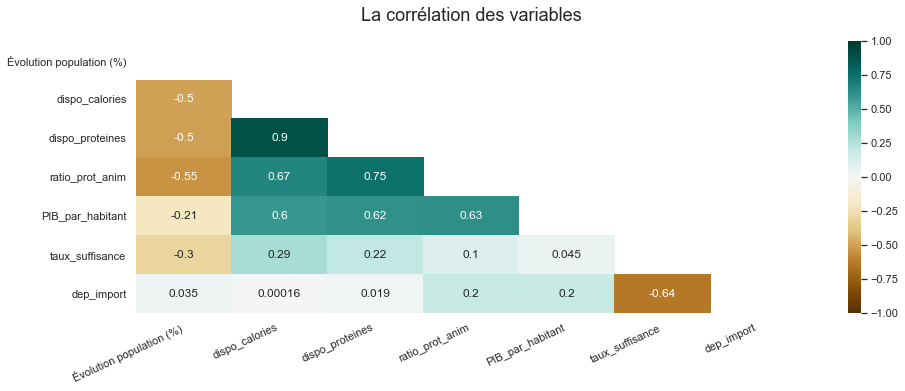

In [29]:
plt.figure(figsize=(15,5))

mask = np.zeros_like(df_clus.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_clus.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.xticks(rotation=25, ha='right')
plt.title('La corrélation des variables',  fontsize=18, pad=20)
plt.savefig('exports/La corrélation des variables.')
plt.show()

#### Observations
on peut vérifier la corrélation des variables avec une matrice des corrélations. 
On peut constater une corrélation positive forte entre  la dispo en protéines et la dispo en calories , le ratio de protéines animales, le PIB.
Dans une moindre mesure, on retrouve également une corrélation négative entre le pourcentage d'évolution de la population et les différents régimes alimentaires des pays. 
On note une relation négative entre l'autosuffisance et le pourcentage de dépendance aux importations

**Nous sommes intéressés par les pays les plus susceptibles de consommer du poulet, donc ceux ayant un fort ratio de protéines animales. Les corrélations montrent que ces pays sont susceptibles d'avoir un fort PIB, et de grandes disponibilités en protéines et calories. 
Nous nous intéressons également aux pays dépendants des importations qui ne sont pas autosuffisants.**

## Classification des pays via Clustering Hiérarchique Ascendant (CHA)

La classification sera établie sur la base des variables suivantes :

**La différence de population entre l'année 2013 et l'année 2019, exprimée en pourcentage;\
La proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays;\
La disponibilité alimentaire en grammes de protéines par habitant ;\
La disponibilité alimentaire en Kcal par habitant.\
PIB par habitant.\
Rapport de dépendance à l'importation.\
La taux suffisance(٪).**

L'échantillon comporte peu de variables sur la dimension dite du "Régime alimentaire" et et variables économiques, il comporte également un nombre de pays "maîtrisables" qui permet de commencer par une classification hiérarchique. Algorithme qui a une forte complexité algorithmique en temps et en espace, le clustering hiérarchique est recommandé pour les petits échantillons.



Le clustering permet de regrouper des individus similaires, c'est-à-dire qu'il va partitionner l'ensemble des individus. On cherche donc à ce que les groupes soient :

    **Resserrés sur eux-mêmes : deux points qui sont proches devraient appartenir au même groupe.
  
    **Loin les uns des autres, c’est-à-dire qu’ils soient fortement différenciés.

Au préalable, il est nécessaire de centrer-réduire les données. C’est à dire, recalculer chaque valeur de manière à ce que la moyenne de la variable soit égale à 0 et la variance et l’écart-type égalent 1. Pour une variable donnée, on soustrait à chaque valeur la moyenne de la variable, puis on divise le tout par l’écart-type.

Ensuite, nous pouvons procéder à la classification ascendante hiérarchique selon la méthode de Ward. 


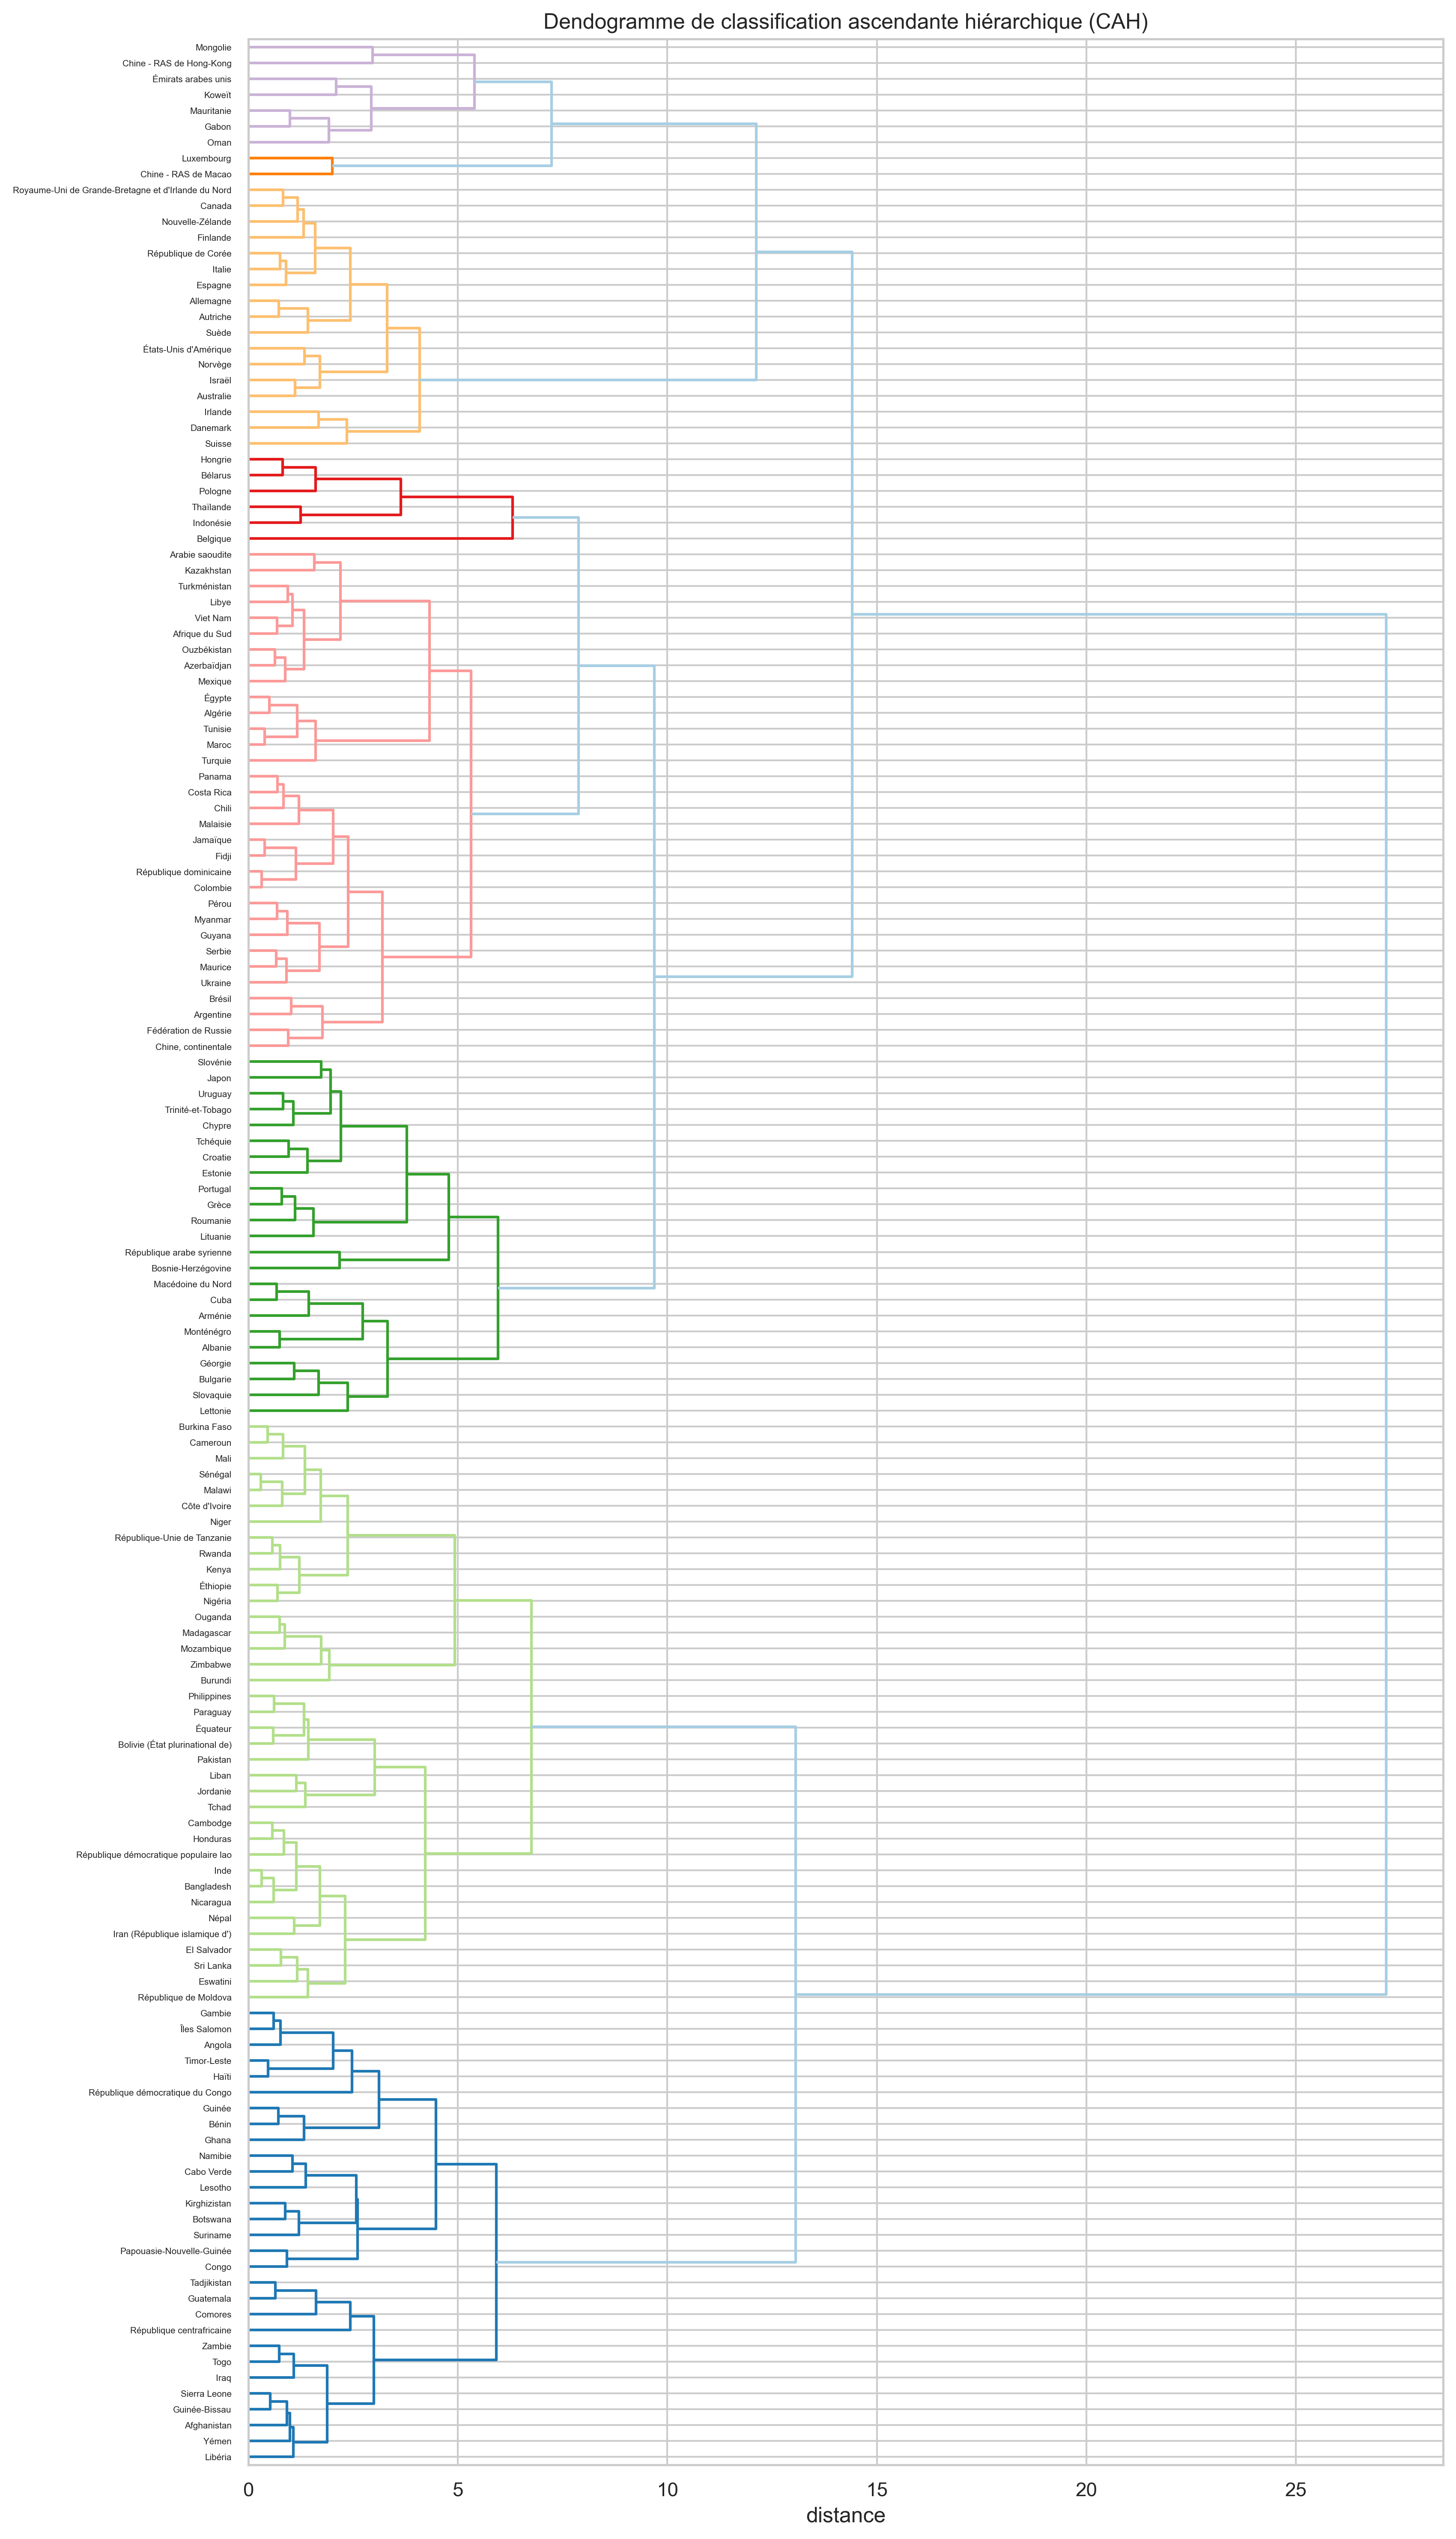

In [30]:

from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram


# dans array numpy
X = df_clus.values 
#nous allons extraire les données d'expression de 153 pays  dans un tableau de données numériques .
 #X comporte uniquement les données  , il ne contient pas les étiquettes des échantillons.

pays = df_clus.index
 #Conservons les étiquettes de chaque échantillon  dans la variable pays.

#centering and reduction
#il est nécessaire de centrer-réduire les données. C’est à dire, recalculer chaque valeur de manière à ce que 
#la moyenne de la variable soit égale à 0 et la variance et l’écart-type égalent 1. Pour une variable donnée,
#on soustrait à chaque valeur la moyenne de la variable, puis on divise le tout par l’écart-type.


std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
#Standardisez les caractéristiques en supprimant la moyenne et  en divisant par l'écart type

#X_scaled =array([[-0.90652015,  0.30068128,  0.61600031, ..., -0.47817227,
        #-1.15900796,  0.84483273],
       #[ 1.29355645, -1.35075836, -1.15709131, ..., -0.68784567,
        #-0.7198978 ,  0.54941119],...,

        

# Clustering hiérarchique avec librairie scipy
z=linkage(X_scaled, method='ward' ,metric='euclidean')
#euclidien pour mesurer la distance entre les observations au sein d'une classe
#ward pour mesurer la distance entre les rangées

# Affichage du dendogramme
plt.figure(figsize=(12,25), dpi=300)
plt.title('Dendogramme de classification ascendante hiérarchique (CAH)')
plt.xlabel('distance')
dendrogram(
    z,#Regroupement hiérarchique encodé avec la matrice renvoyée par la fonction de linkage.
    labels = pays,
    orientation = "right",
    color_threshold=7
)
plt.savefig('exports/dendogram_CAH_1.png')
plt.show()

Une fois le dendrogramme obtenu, nous pouvons choisir en combien de clusters nous pouvons diviser notre arbre. Ici, une partition en 5 clusters permet d’avoir des groupes de taille raisonnable à analyser.

Graphiquement, on voit bien que la méthode de Ward a permis de minimiser les distances intra-classes à chaque regroupement.


Essayons de caractériser chacun de ces clusters en regardant la valeur de leurs centroïde pour chaque variable. Les centroïdes représentent tout simplement la valeur moyenne d’une variable pour un cluster donné.
Différences entre les clusters :

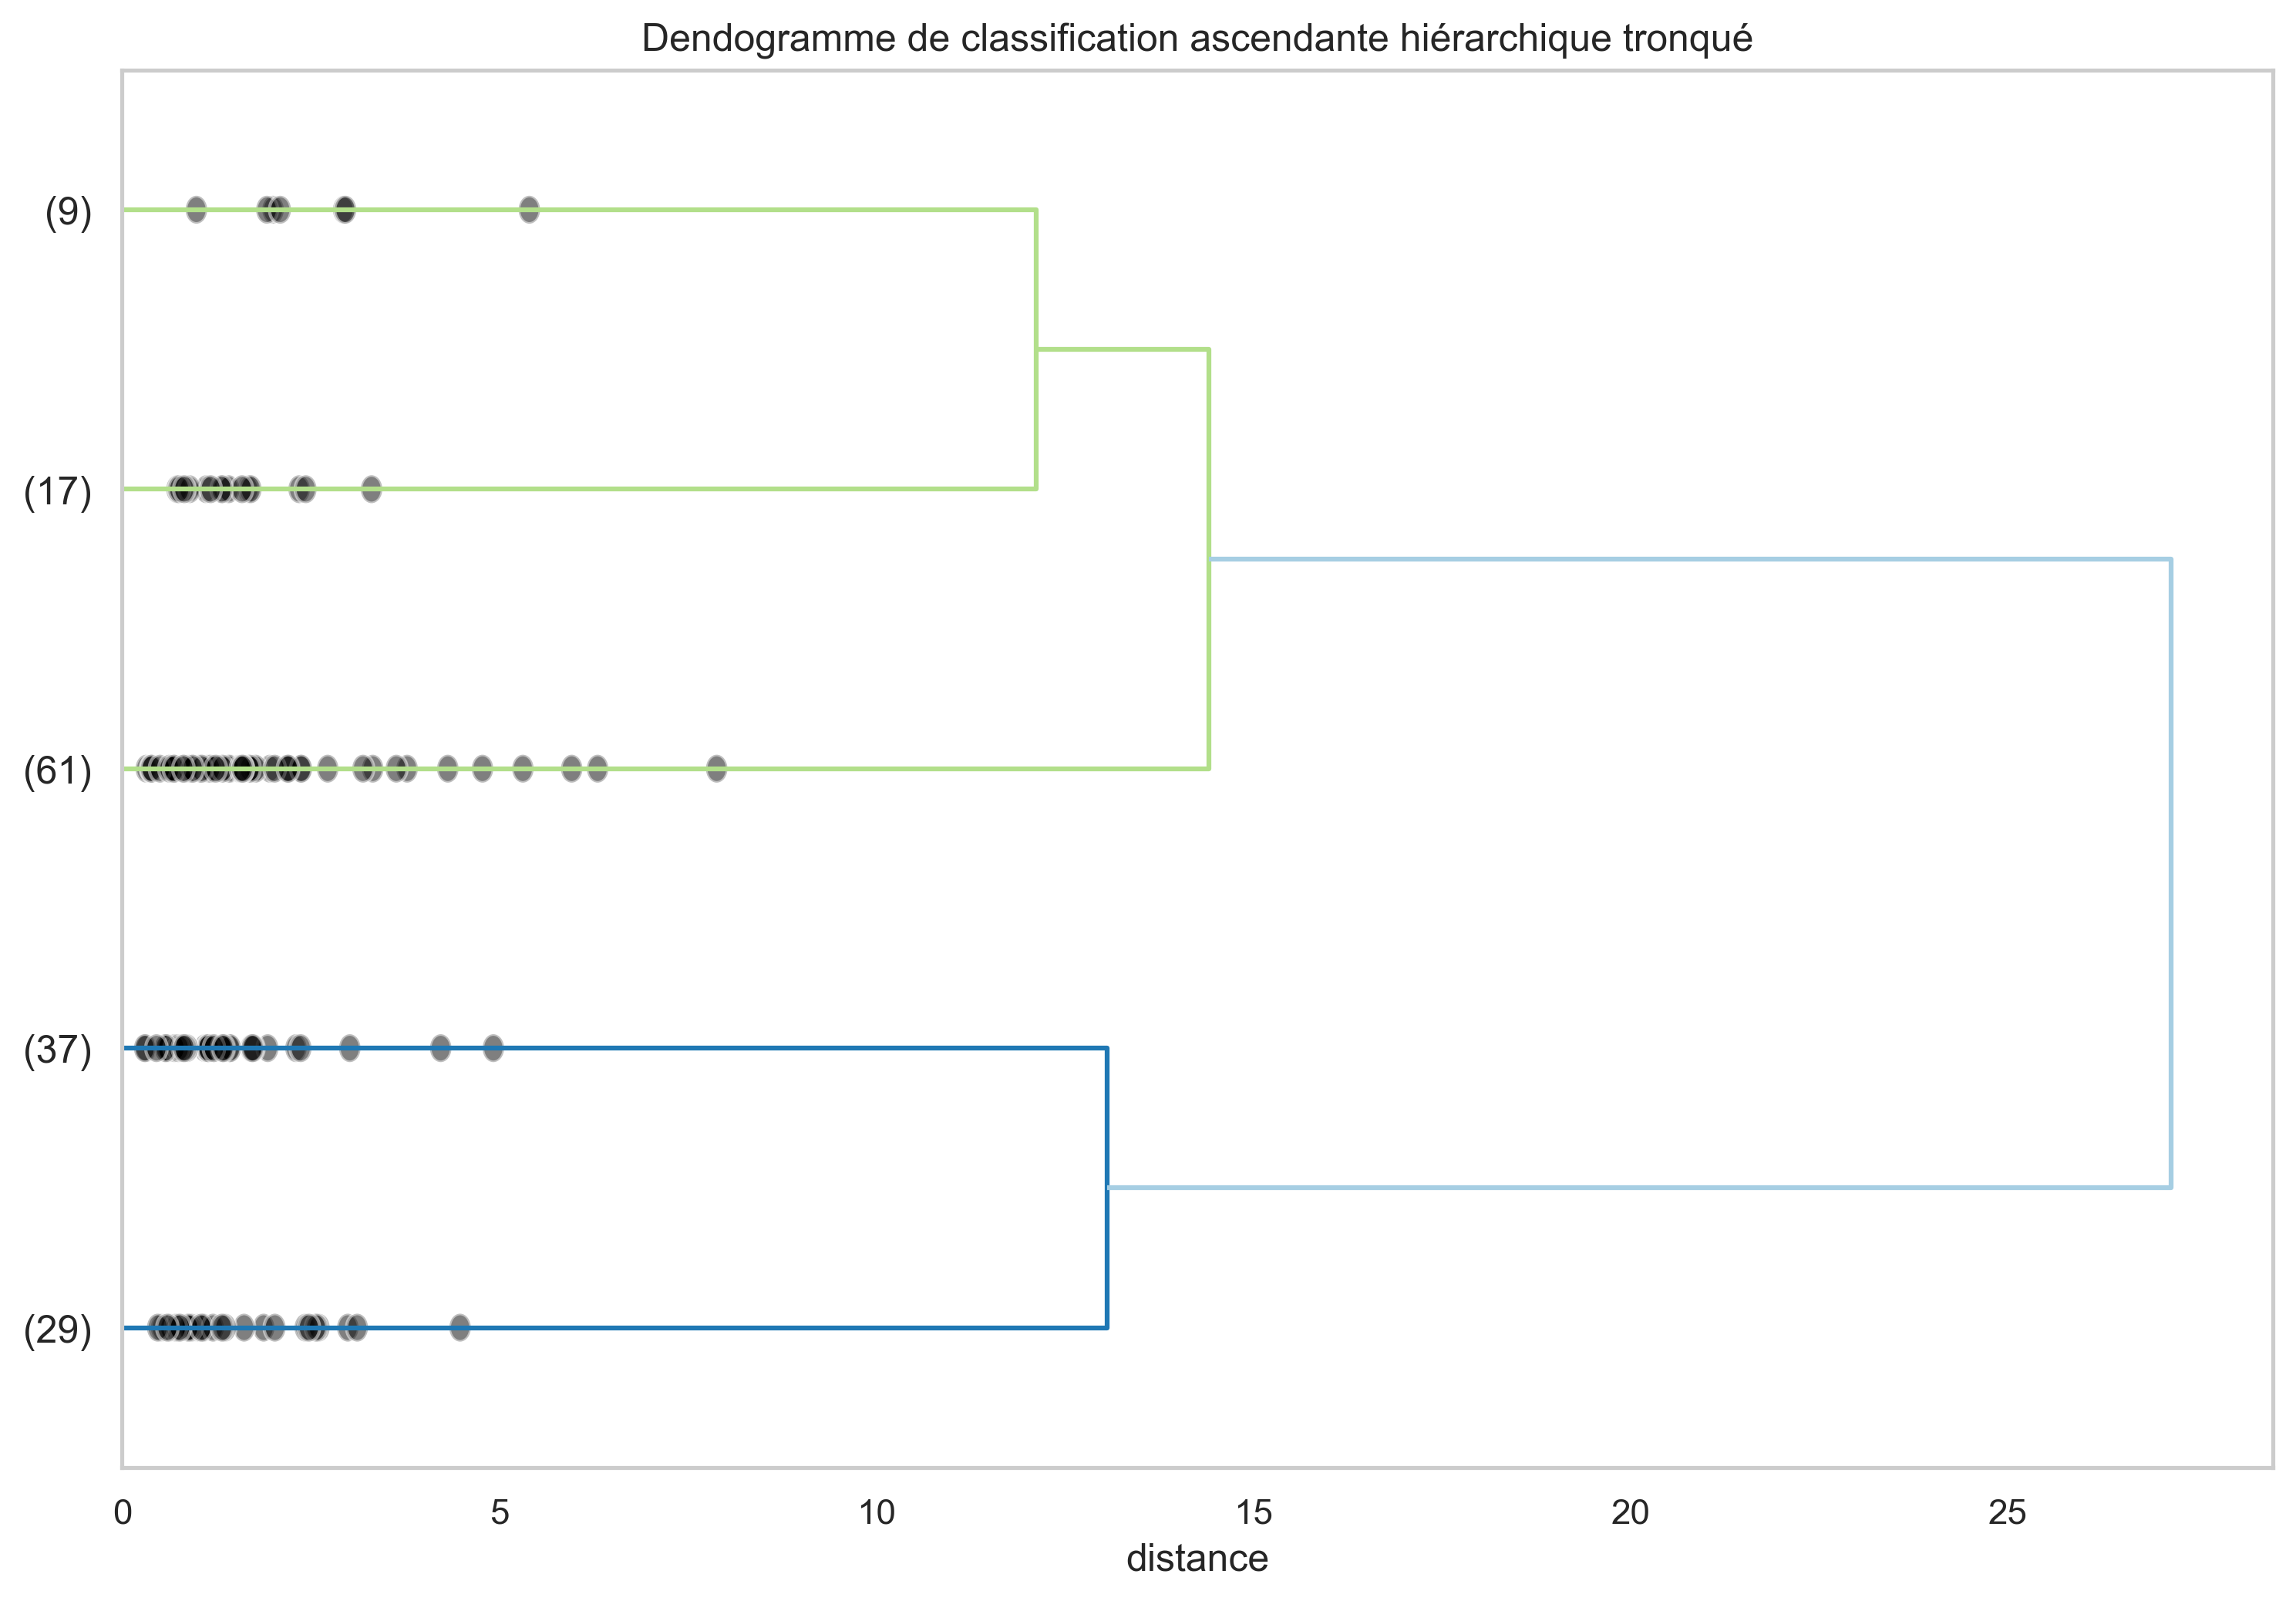

In [31]:
plt.figure(figsize=(12,8), dpi=300)
plt.title('Dendogramme de classification ascendante hiérarchique tronqué')
plt.xlabel('distance')
plt.grid(False)
dendrogram(
    z,      #linkage(X_cr, method='ward' ,metric='euclidean'),
    truncate_mode='lastp', #Les p derniers clusters non singleton formés dans la liaison sont les seuls nœuds non feuilles dans la liaison ; 
    p = 5,
    labels = pays,
    orientation = "right",
    show_contracted=True,)
plt.savefig('exports/dendogram_CAH_truncated_1.png')
plt.show()



## Attribution des 5 groupes et World map de répartition

In [32]:
# Coupage du dendrogramme en 5 clusters avec Scipy
groupe_cah = fcluster(z, 5, criterion='maxclust')
#array([2, 1, 4, 5, 2, 2, 5, 3, 3, 2, 4,....
#fcluster: formez des clusters plats à partir du clustering hiérarchique défini par la matrice de liaison donnée.

#affichage des pays et leurs groupes
df_groupage_1 = pd.DataFrame(columns=["groupe_cah","pays"])
df_groupage_1["pays"] = df_clus.index
df_groupage_1["groupe_cah"] = groupe_cah

df_groupage_1

,groupe_cah,pays
0,3,Arménie
1,1,Afghanistan
2,3,Albanie
3,3,Algérie
4,1,Angola
...,...,...
148,1,Zambie
149,3,Belgique
150,5,Luxembourg
151,3,Serbie


In [33]:
# Jointure pour ajout des groupes dans le dataframe principal
df_groupes_cah = pd.merge(df_clus, df_groupage_1, on="pays")
df_groupes_cah.to_csv('exports/groupes_cah.csv', index=False)
df_groupes_cah.sample(5)

,pays,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import,groupe_cah
1,Afghanistan,25.36,829645.0,20918.15,18.04,469.919090,41.791045,65.671642,1
126,Suisse,10.21,1233335.0,35463.40,63.10,85134.954826,66.442953,30.201342,4
114,Fédération de Russie,1.74,1227495.0,38262.95,53.30,11605.566389,99.956597,5.034722,3
7,Autriche,6.50,1347215.0,39766.75,59.19,49700.761833,74.576271,63.841808,4
39,Fidji,4.08,1043535.0,28433.50,46.52,6185.100338,89.743590,12.820513,3


## Centroïdes des clusters

In [34]:
#Première comparaison des moyennes afin d'identifier le groupe de pays le plus porteur à ce niveau de l'analyse
df_groupes_cah.groupby('groupe_cah').mean()

,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import
groupe_cah,,,,,,,
1,19.984828,8.766922e+05,21293.093103,29.091724,2110.022285,31.575110,73.675323
2,18.694054,9.254822e+05,23823.155405,26.351351,2351.389836,98.211836,6.476803
3,4.341475,1.150306e+06,33440.163115,48.544426,11584.646909,97.204320,32.123882
4,7.171765,1.269320e+06,39740.985294,60.102941,52522.152529,97.090077,26.222016
5,23.117778,1.132473e+06,35584.255556,55.363333,39216.630661,8.940421,115.796414


In [35]:
#Préparation de sous-ensembles permettant de caractériser les groupes un à un
df_groupe1_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 1]
df_groupe2_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 2]
df_groupe3_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 3]
df_groupe4_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 4]
df_groupe5_cah = df_groupes_cah[df_groupes_cah['groupe_cah'] == 5]



In [36]:


#Pays du groupe 1 et 2 identifiés comme potentiellement intéressants

print('groupe 1')
print('----------')
print(df_groupe1_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('groupe 2')
print('----------')
print(df_groupe2_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('groupe 3')
print('----------')
print(df_groupe3_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('groupe 4')
print('----------')
print(df_groupe4_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('groupe 5')
print('----------')
print(df_groupe5_cah['pays'].unique())
print('------------------------------------------------------------')
print('------------------------------------------------------------')






groupe 1
----------
['Afghanistan' 'Angola' 'Botswana' 'Îles Salomon' 'Cabo Verde'
 'République centrafricaine' 'Comores' 'Congo' 'Bénin' 'Gambie' 'Ghana'
 'Guatemala' 'Guinée' 'Haïti' 'Iraq' 'Kirghizistan' 'Lesotho' 'Libéria'
 'Namibie' 'Papouasie-Nouvelle-Guinée' 'Guinée-Bissau' 'Timor-Leste'
 'Sierra Leone' 'Suriname' 'Tadjikistan' 'Togo' 'Yémen'
 'République démocratique du Congo' 'Zambie']
------------------------------------------------------------
------------------------------------------------------------
groupe 2
----------
['Bangladesh' 'Bolivie (État plurinational de)' 'Burundi' 'Cameroun'
 'Sri Lanka' 'Tchad' 'Équateur' 'El Salvador' 'Honduras' 'Inde'
 "Iran (République islamique d')" "Côte d'Ivoire" 'Jordanie' 'Kenya'
 'Cambodge' 'République démocratique populaire lao' 'Liban' 'Madagascar'
 'Malawi' 'Mali' 'Mozambique' 'République de Moldova' 'Népal' 'Nicaragua'
 'Niger' 'Nigéria' 'Pakistan' 'Paraguay' 'Philippines' 'Zimbabwe' 'Rwanda'
 'Sénégal' 'Eswatini' 'République-Un

## Description et critique des clusters

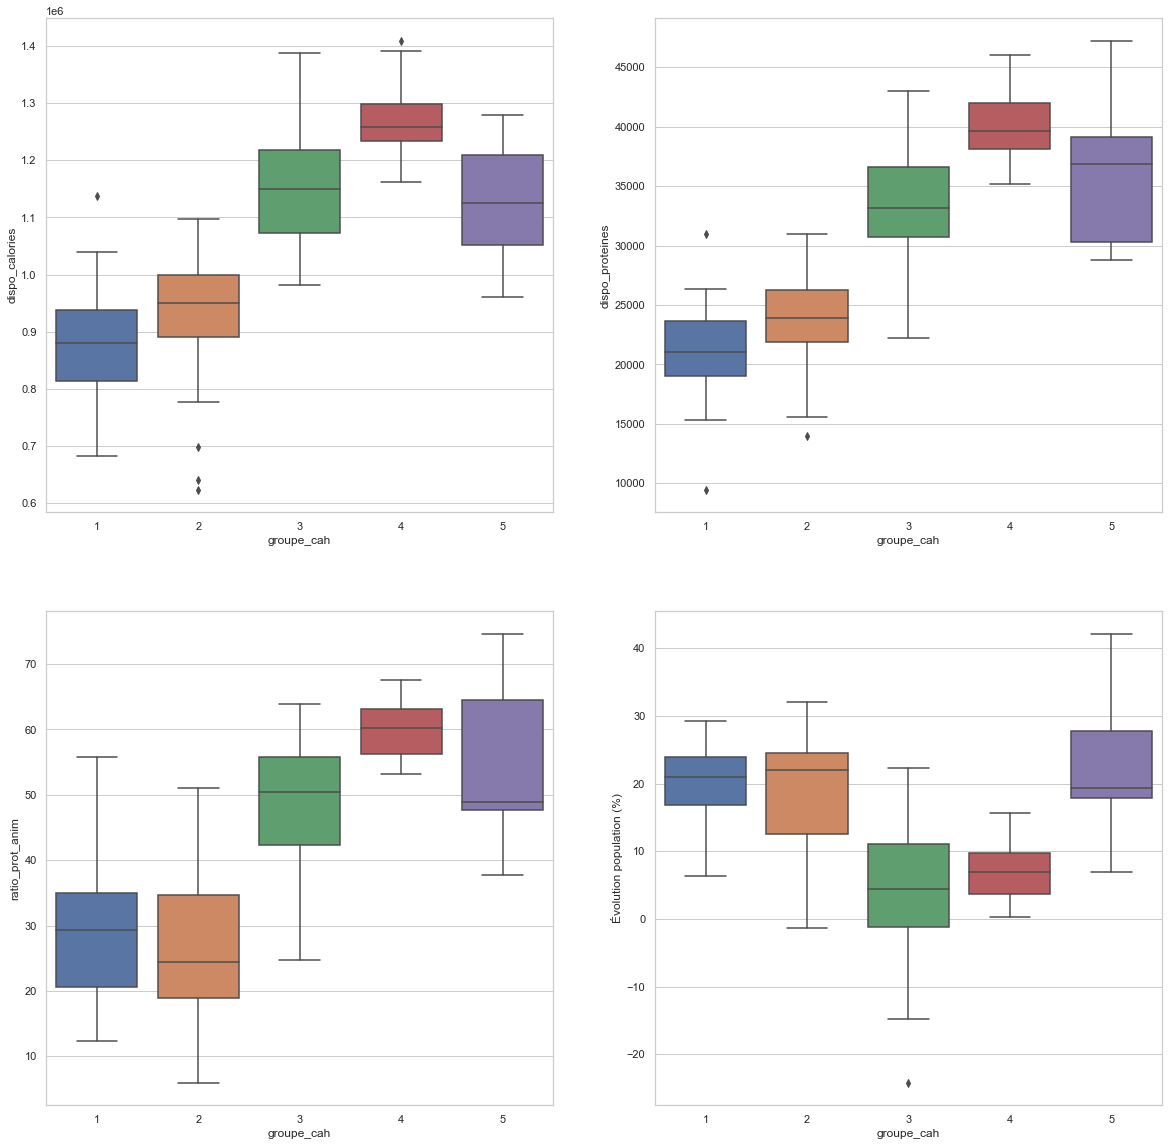

In [37]:


#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='dispo_calories')


plt.subplot(222)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='dispo_proteines')

plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='ratio_prot_anim')

plt.subplot(224)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='Évolution population (%)')


plt.savefig("exports/boxplot_dendogramme3.png")




plt.show(block=False)

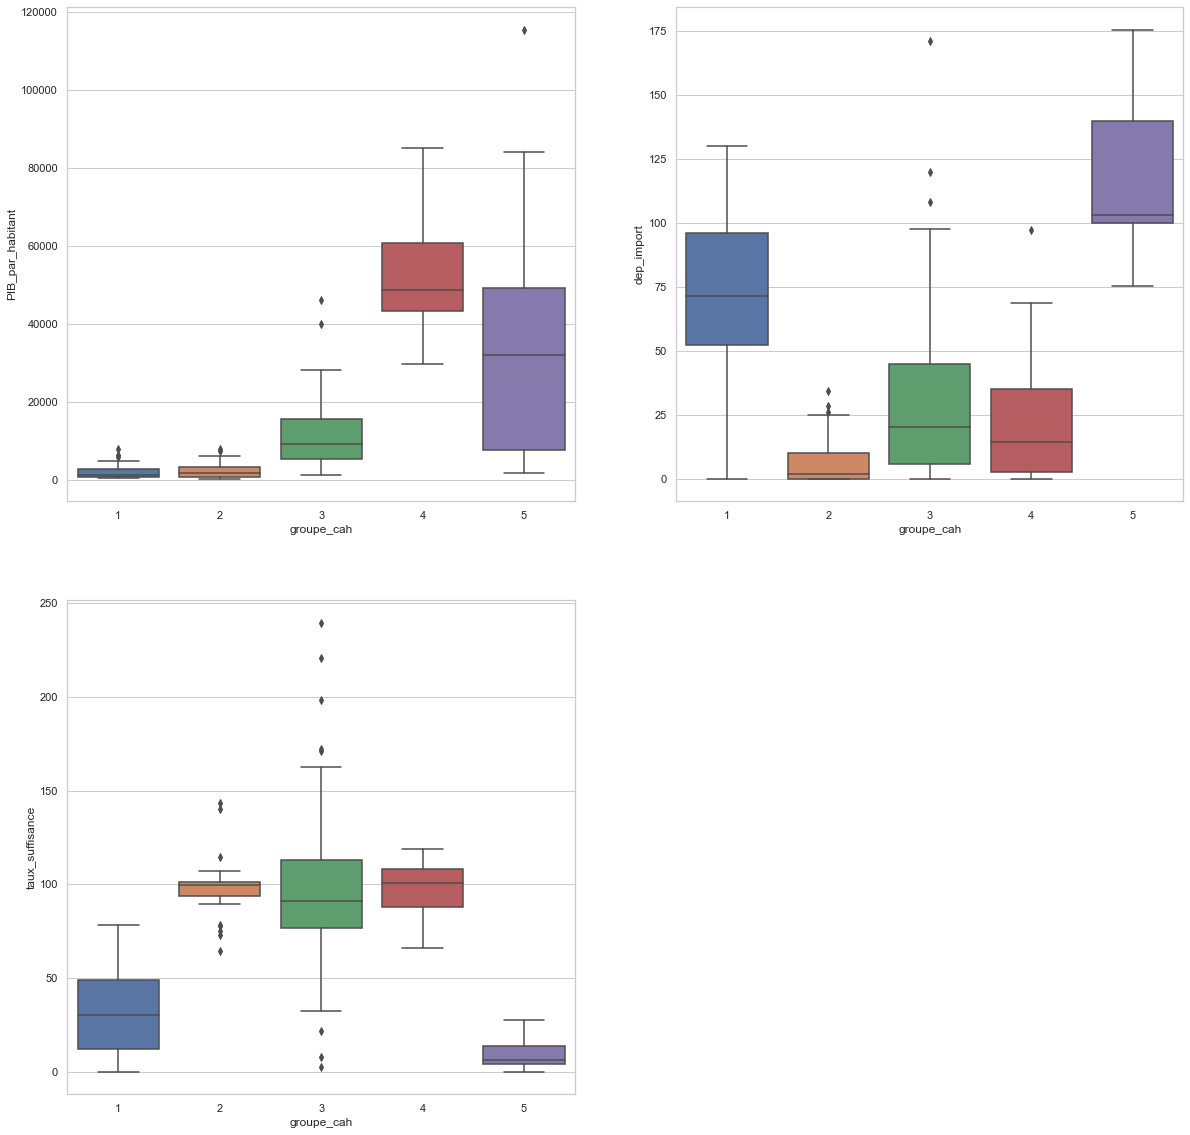

In [38]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='PIB_par_habitant')


plt.subplot(222)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='dep_import')


plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='groupe_cah', y='taux_suffisance')


plt.savefig("exports/boxplot_dendogramme3.png")




plt.show(block=False)

Description et critique des clusters 

Les groupes 1 et 2, situés principalement en Afrique, ont la démographie la plus forte et le PIB par habitant le plus bas. 

Les groupes 4 et 5, au contraire, reflètent des pays plus riches en moyenne, comme les États-Unis et la plupart des pays européens. 

Fait intéressant, le groupe 5 a un PIB décent et une bonne croissance démographique

En termes de disponibilité alimentaire, ces tendances suivent les mêmes tendances que le PIB. Les pays les plus pauvres ont moins accès à la nourriture. 

La consommation de protéines animales confirme le partage, avec une forte alimentation carnée de la part des groupes 3,4 et 5 
On voit que les groupes 2 et 5 importent beaucoup plus de viande de volaille qu'ils n'en produisent. 

En fait, ils ont les taux d'autosuffisance les plus bas. Au contraire, les groupes 2, 3 et 4 sont raisonnablement autosuffisants. 

 
Compte tenu de tous ces critères, quel groupe serait apte à être sélectionné comme candidat pour notre marché international ? 

 Je pense que les groupes qui dépendent fortement des importations sont les meilleures cibles pour nos ventes.
Nous choisirons le groupe 5 car il est fortement dépendant des importations, a un taux de croissance démographique élevé et un PIB par habitant élevé.


Nous choisissons également le groupe 4, car le PIB par habitant est beaucoup plus élevé dans ces pays, ce qui nous permettra de vendre notre production plus facilement et à un meilleur prix. Et le plus élevé en termes de consommation de protéines animales et de calories. Il comprend également des pays géographiquement proches de la France.
 

In [39]:
df_select_pays_cah = df_groupes_cah[df_groupes_cah["groupe_cah"].isin([4,5]) == True]

df_select_pays_cah.to_csv('exports/Sélections des pays sur CAH.csv', index=False)
df_select_pays_cah.shape
df_select_pays_cah

,pays,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import,groupe_cah
6,Australie,13.70,1247205.0,39398.10,67.55,54763.202388,102.815768,0.724055,4
7,Autriche,6.50,1347215.0,39766.75,59.19,49700.761833,74.576271,63.841808,4
17,Canada,9.80,1291735.0,39620.75,56.31,46550.335507,97.852960,11.646064,4
32,Danemark,4.25,1248665.0,42113.70,66.49,60656.938517,108.219178,97.260274,4
40,Finlande,3.43,1211800.0,42876.55,62.15,48678.365212,118.803419,14.529915,4
42,Gabon,27.78,961045.0,28809.45,47.62,7773.198920,5.263158,94.736842,5
44,Allemagne,3.13,1299035.0,38047.60,60.15,46231.563366,90.186916,48.539720,4
53,Chine - RAS de Hong-Kong,6.88,1181140.0,47249.25,74.66,49180.094302,4.318182,175.681818,5
60,Irlande,7.95,1391015.0,40533.25,57.05,81636.578555,111.594203,68.840580,4
61,Israël,15.60,1298670.0,46026.50,60.56,46376.466510,100.816993,0.000000,4


In [40]:
df_select_pays_cah.shape

(26, 9)

En conclusion pour cette première section, 26 pays sont susceptibles de devenir une cible appropriée pour l'entreprise. La demande sera présente dans ces pays. Appliquons une autre méthode, la méthode K-Means, afin de pouvoir comparer cette première sélection.

# Mission 3 : Analyse en Composantes Principales (ACP)



Le clustering K-Means est une méthode de clustering simple mais puissante qui crée 𝑘 segments distincts des données où la variation au sein des clusters est aussi petite que possible. Pour trouver le nombre optimal de clusters, je vais essayer différentes valeurs de 𝑘 et calculer l'inertie, ou score de distorsion, pour chaque modèle.
 L'inertie mesure la similarité du cluster en calculant la distance totale entre les points de données et leur centre de cluster le plus proche. Les clusters avec des observations similaires ont tendance à avoir des distances plus petites entre eux et un score de distorsion plus faible dans l'ensemble.

## La méthode du coude nous aidera à déterminer le nombre de groupes.

•Nous choisissons 'K' manuellement, par visualisation.

• Calculer les distances entre les points d'un cluster (With-in Cluster Sum of Squares "WCSS").

• Si nous minimisons 'WCSS', nous avons atteint la solution de clustering parfaite.


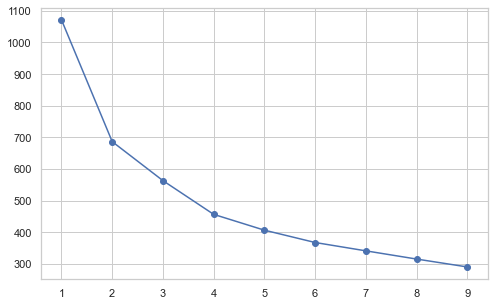

In [41]:
from sklearn.cluster import KMeans
from sklearn import cluster


K=range(1,10)
k_means = []
#On fait une boucle de 1 à 10 pour tester toutes ces possibiliéts
for k in K:
    #pour chaque k, on crée un modèle et on l’ajuste
    km=KMeans(n_clusters=k,init="k-means++").fit(X_scaled)
     #on stocke l’inertie associée
    k_means.append(km.inertia_)


#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.plot(range(1, 10), k_means, marker='o')
plt.show()

In [42]:
mycenters = pd.DataFrame({'groupe_km' : K, 'WSS' : k_means})
mycenters

,groupe_km,WSS
0,1,1071.000000
1,2,686.201480
2,3,562.995456
3,4,456.477323
4,5,406.511943
5,6,367.565206
6,7,341.206162
7,8,315.275694
8,9,290.347825


On remarque que le nombre de 5 Clusters n'est pas idéal pour le Kmeans. La meilleure alternative serait 2 Clusters. Si l'on veut partitionner un peu plus, il faudrait considérer un K = 3 ou 4.

il est conseillé de choisir k = 5 .
 Un clustering  en 5 permettra de de comparer le partitionnement avec les groupes de la classification hiérarchique. Il est pertinent de comparer les deux méthodes sur le même nombre de clusters.



In [43]:

#Clustering K-Means en 5 clusters
km = cluster.KMeans(n_clusters=5)
km.fit(X_scaled)
#Récupération des clusters attribués à chaque individu (classes d'appartenance)
clusters_km = km.labels_
clusters_km



array([3, 2, 3, 4, 2, 4, 1, 1, 0, 0, 2, 4, 2, 3, 4, 0, 0, 1, 2, 2, 0, 0,
       4, 4, 4, 0, 2, 4, 3, 4, 4, 2, 1, 4, 4, 0, 4, 4, 3, 4, 1, 3, 2, 2,
       1, 4, 2, 4, 0, 2, 4, 2, 0, 3, 4, 4, 0, 0, 4, 2, 1, 1, 4, 0, 3, 4,
       4, 0, 2, 0, 0, 4, 1, 3, 0, 0, 2, 2, 4, 4, 1, 0, 0, 4, 0, 2, 4, 4,
       3, 4, 0, 4, 2, 0, 3, 1, 0, 0, 0, 1, 0, 4, 3, 2, 0, 4, 0, 4, 4, 2,
       2, 0, 4, 0, 4, 4, 0, 2, 4, 3, 4, 4, 2, 2, 0, 1, 1, 4, 4, 0, 4, 0,
       4, 2, 4, 4, 3, 0, 1, 4, 1, 0, 4, 4, 4, 0, 2, 2, 0, 1, 1, 4, 3],
      dtype=int32)

# Visualisation des clusters en ACP pour la projection des données


Le principe de **la réduction de dimension** est de réduire la complexité superflue d'un dataset en projetant ses données dans un espace de plus petite dimension .

Le principe  de **ACP** est de projeter nos données sur des axes appelés Composantes Principales, en cherchant à minimiser la distance entre nos points et leur projections. De cette manière on réduit la dimension préservant au maximum la variance de nos données. Pour **Préserver un maximum de variance pour optenir la projection qu'il soit la plus fidèle possible à nos données.**
 
 Analyse Pour trouver les axes de projection (xp): 
 Pour faire ça dans point de vue mathématique on
 1. On calcule la matrice de covariance des données 
 2. On détermine les vecteurs propres de cette matrice : ce sont les Composantes Principales 
 3. (On projette les données sur ces axes)
 


 
**L'ACP (Analyse en Composante Principale) permettra une visualisation des clusters pays sur le premier plan factoriel (ou plus). Il deviendra alors facile de pouvoir appréhender le "comportement" des différents groupes.**

PCA est un transformer ! 
1. Définir le nombre de composantes 
2. Transformer les données avec fit transform()

Il y a deux cas possibles pour choisir le nombre de composantes sur lesquels projeter nos données? et bien :
1. Celui dans lequel vous cherchez à visualiser vos données dans un espace de 2d ou 3D ,pour ça c'est très simple, le nombre de composants doit être égale à deux ou trois
2. Celui dans lequel vous cherchez à compresser vos données pour accélérer l'apprentissage de la machine sur des taches de classification ou de régression, pour ça il faut choisir le nombre de composantes de telle sorte à préserver entre 95 et 99 % de la variance de vos données.


L’enjeu d’une ACP est de trouver le meilleur plan de projection ayant la plus grande inertie, c’est à dire limitant le plus la perte d’information originelle. Les 7 variables seront synthétisées en de nouvelles variables : PC1, PC2, etc...

Comme précédemment, une ACP ne peut se faire que si les données sont centrées et réduites (transformation pour que moyenne = 0, écart-type = 1).

### Définir le nombre de composantes 

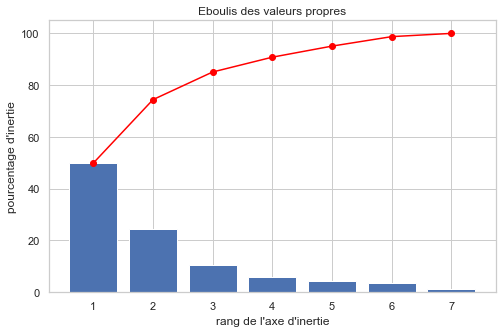

[ 49.88630268  74.40480868  85.08814597  90.81243941  95.08681732
  98.74761217 100.        ]


In [44]:
import pca as pca
from sklearn import decomposition

#decomposition.PCA: Réduction de la dimensionnalité linéaire à l'aide de la décomposition en valeurs singulières des données pour les projeter dans un espace de dimension inférieure.
pca = decomposition.PCA().fit(X_scaled) #sklearn
X_projected = pca.transform(X_scaled)


#nous allons examiner quel est le pourcentage de variance préserver pour chacune de nos composantes.
scree = pca.explained_variance_ratio_*100      #Le paramètre pca.explained_variance_ratio_ renvoie un vecteur de la variance expliquée par chaque dimension.
#array([49.88630268, 24.51850599, 10.68333729,  5.72429344,  4.27437791,3.66079486,  1.25238783])

plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')   
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.savefig("exports/Eboulis des valeurs propres.png")

plt.show()

#Pourcentage de variance expliquée par les composantes principales à l'aide de .explained_variance_ratio_
print(scree.cumsum())





In [45]:
scree 

array([49.88630268, 24.51850599, 10.68333729,  5.72429344,  4.27437791,
        3.66079486,  1.25238783])

Environ 75 % de la variance des données s'explique par ces deux premières composantes.
La méthode du coude précise une forte représentation de nos variables sur les deux premières composantes principales, le premier axe factoriel.


# ACP - Cercle des corrélations

In [46]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            #fig, ax = plt.subplots(figsize=(12,(n_comp*2)))
            #ax.set_aspect('equal', adjustable='box')
            fig=plt.figure(figsize=(12,12))
            fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=fig.add_subplot(111)
            ax.set_aspect('equal', adjustable='box')

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            else :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
        
            # affichage des flèches
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.savefig("exports/Cercle des corrélations (F1 et F2).png")

            plt.show(block=False)

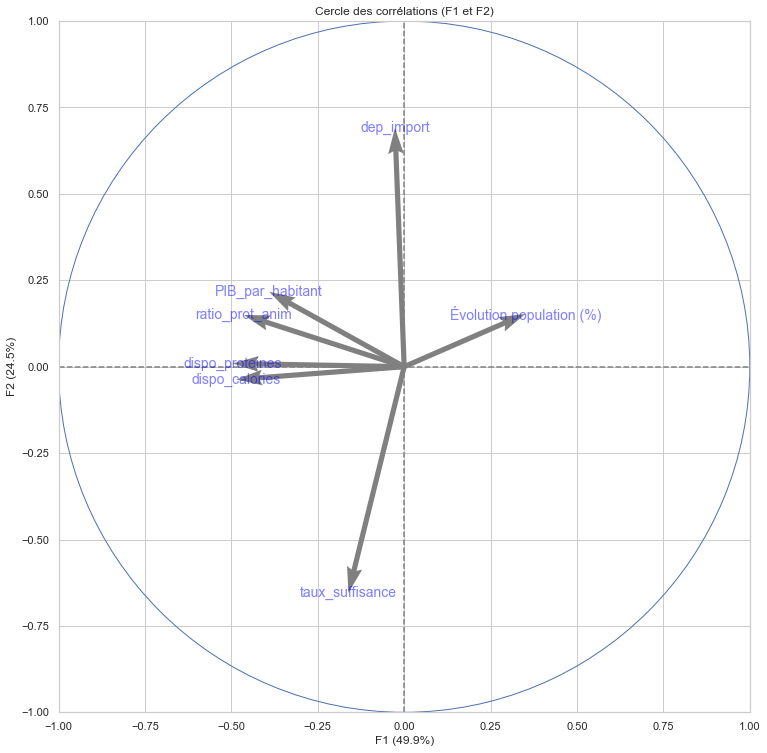

In [47]:
pcs = pca.components_
cerle_corr(pcs, 4, pca, [(0,1)], labels = np.array(df_clus.columns))

Dans notre étude, le premier plan factoriel de l’ACP a permis de conserver 75 % de l’information totale.

Ici, l’axe PC2 reflète bien le taux de dépendance aux importations et le taux d’autosuffisance. Plus la valeur de l’axe 2 est positive, et plus le pays est importateur. Au contraire, plus les valeurs sont négatives, et plus le pays est autosuffisant avec sa production de viande de volailles et importe peu. 

De même, l'axe PC1 est une combinaison de la disponibilité totale de protéines et de calories, du PIB, de la proportion de protéines animales et de l'évolution de la population. 

Plus la forte croissance démographique d'un pays est importante, plus sa valeur positive sur l'axe PC1 est élevée. 

À l'inverse, plus la valeur de l'axe PC1 est négative, plus le PIB du pays est élevé, plus la consommation de protéines animales et la disponibilité alimentaire de protéines et de calories sont élevées. 

La protéine  est la variable qui contribue le plus à l'axe PC1. 
Enfin, il existe une certaine relation entre les variables du PIB, la proportion de protéines animales et la disponibilité de protéines totales et de calories.  

 

On peut d'ailleurs calculer les valeurs de ces variables synthétiques F1 et F2 qui pourraient remplacer les autres variables :



In [48]:
X_projected

array([[-0.83309518,  1.44335762, -1.29818808, ..., -0.46053768,
        -0.2576511 ,  0.05195511],
       [ 2.69797624,  0.89730533,  0.25384579, ...,  0.28864918,
         0.20985637,  0.24145512],
       [-1.84654041,  0.90710747, -1.37119198, ..., -0.32586826,
         0.08362984,  0.4210577 ],
       ...,
       [-3.36674258,  3.58642842,  2.8560993 , ..., -0.56468404,
         1.52688994, -0.0383078 ],
       [-0.76916016, -0.76814735, -1.15687201, ..., -0.52900622,
         0.00482958,  0.1115594 ],
       [-2.08924856,  1.06435542, -1.02357145, ..., -0.19630919,
        -0.25544654, -0.03449507]])

In [49]:
#Calcul des composantes principales
#Ici seulement F1 et F2 seront utiles à l'interprétation attendue
X_projected = pca.transform(X_scaled)

df_facto = pd.DataFrame(X_projected, index=df_clus.index, columns=["F" + str(i+1) for i in range(7)]).iloc[:, :2]
df_facto.head() #Affichage des 5 premières lignes



,F1,F2
pays,,
Arménie,-0.833095,1.443358
Afghanistan,2.697976,0.897305
Albanie,-1.846540,0.907107
Algérie,-0.106495,-1.170818
Angola,2.466037,1.798502


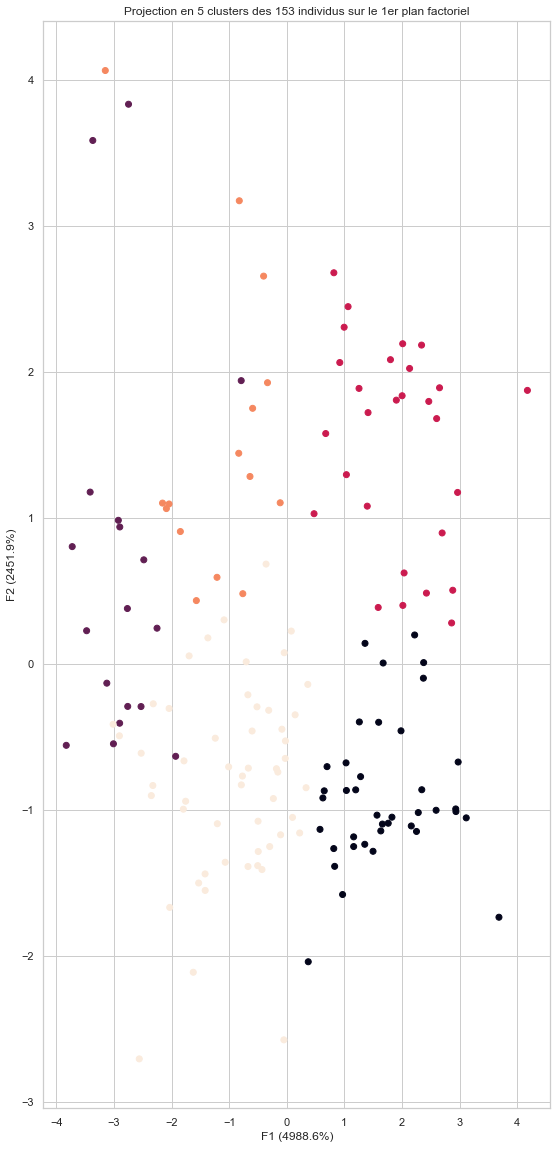

In [50]:
#pca = decomposition.PCA().fit(X_scaled) #sklearn
#X_projected = pca.transform(X_scaled)


#Coordonnées factorielles 
plt.figure(figsize=(20,20))
plt.subplot(122)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=km.labels_)
plt.xlabel('F{} ({}%)'.format(1, round(100*scree[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*scree[1],1)))
plt.title("Projection en 5 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.savefig("exports/projection_clusters.png")
plt.show()

On obtient donc un tableau de 5 lignes et 7 colonnes, pourquoi ?
Nous avons cinq groupes et sept variables.
**Pour réduire les dimensions, nous avons besoin de pca**

L'analyse sera plus fine en 5 clusters. De plus, la comparaison sera possible avec les 5 groupes identifiés lors du précédent partitionnement, le contexte nous oriente davantage vers un clustering en 5 partitions.

Maintenant, il est nécessaire de caractériser chacun de ces groupes selon nos 8 variables. La position des centroïdes de chacun des groupes indiquera le ou les meilleurs clusters. C'est l'avantage de procéder en K-Means, afin d'obtenir directement des valeurs centrées et réduites, facilitant l'analyse. ⬇️

In [51]:
df_groupes_cah['groupe_km'] = clusters_km
gb = df_groupes_cah.groupby('groupe_km')
nk = gb.size()
print(nk)


groupe_km
0    39
1    18
2    28
3    15
4    53
dtype: int64


In [52]:
# Moyennes conditionnelles
mk = gb.mean()
mk

,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import,groupe_cah
groupe_km,,,,,,,,
0,19.906154,9.156446e+05,23366.644872,25.895128,2170.156789,96.621556,7.783184,1.923077
1,10.641111,1.275026e+06,39673.269444,60.335556,59755.742894,90.208478,50.044283,4.111111
2,20.943929,8.934939e+05,22074.026786,31.210000,2787.841577,25.571228,83.086780,1.428571
3,2.523333,1.148898e+06,34624.873333,55.210667,15932.509175,38.333615,92.219588,3.400000
4,5.167736,1.145177e+06,33430.143396,47.205660,11762.171925,104.282695,17.163396,3.000000


In [53]:
# Ajout des variables synthétiques F1 et F2
df_boxkm = pd.merge(df_groupes_cah, df_facto, on="pays", how="left")
df_boxkm = df_boxkm.sort_values("groupe_km")
df_boxkm.head()


,pays,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import,groupe_cah,groupe_km,F1,F2
90,Mozambique,24.60,777450.0,17264.50,15.39,503.745209,93.333333,20.000000,2,0,2.976022,-0.672130
70,Cambodge,14.51,985500.0,23918.45,28.57,1643.641451,77.777778,2.777778,2,0,1.282264,-0.772194
69,Kenya,22.20,804825.0,22334.35,24.78,1816.523795,104.705882,0.000000,2,0,2.162225,-1.110062
25,Comores,20.88,834025.0,21013.05,32.36,1370.149168,20.000000,0.000000,1,0,2.220785,0.198385
67,Jordanie,31.76,923085.0,23257.80,39.47,4405.480596,78.059072,26.160338,2,0,1.673708,0.006214


In [54]:
#les centroïdes des groupes et leurs coordonnées dans chacune des dimensions.
les_centroïdes_groupes= df_boxkm.groupby('groupe_cah').mean()
df_select_pays_cah.to_csv('exports/les centroïdes des groupes et leurs coordonnées dans chacune des dimensions.csv', index=False)

les_centroïdes_groupes

,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import,groupe_km,F1,F2
groupe_cah,,,,,,,,,,
1,19.984828,8.766922e+05,21293.093103,29.091724,2110.022285,31.575110,73.675323,1.724138,2.041918,1.221581
2,18.694054,9.254822e+05,23823.155405,26.351351,2351.389836,98.211836,6.476803,0.324324,1.569467,-0.957165
3,4.341475,1.150306e+06,33440.163115,48.544426,11584.646909,97.204320,32.123882,3.688525,-1.004732,-0.440722
4,7.171765,1.269320e+06,39740.985294,60.102941,52522.152529,97.090077,26.222016,1.529412,-2.791467,0.033119
5,23.117778,1.132473e+06,35584.255556,55.363333,39216.630661,8.940421,115.796414,2.000000,-0.949146,2.923369


In [55]:
def boxplot_cluster_km(var):
    data_boxplot = []
    groupes_pays = df_boxkm["groupe_km"].unique()
    
    for groupe in groupes_pays :
        subset = df_boxkm[df_boxkm.groupe_km == groupe]
        data_boxplot.append(subset[var])

    fig, ax1 = plt.subplots(figsize=(12, 8))
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data_boxplot, notch=0, vert=1, whis=1.5, labels=["0", "1", "2", "3", "4"])

    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.4)
    ax1.set_axisbelow(True)
    ax1.set_title(("Distribution de " + var +" par Cluster Kmeans"), fontsize=22)
    ax1.set_ylabel(var)
    ax1.set_xlabel("Cluster")
    ax1.set_xlim(0, len(data_boxplot) + 0.5)

    plt.show()

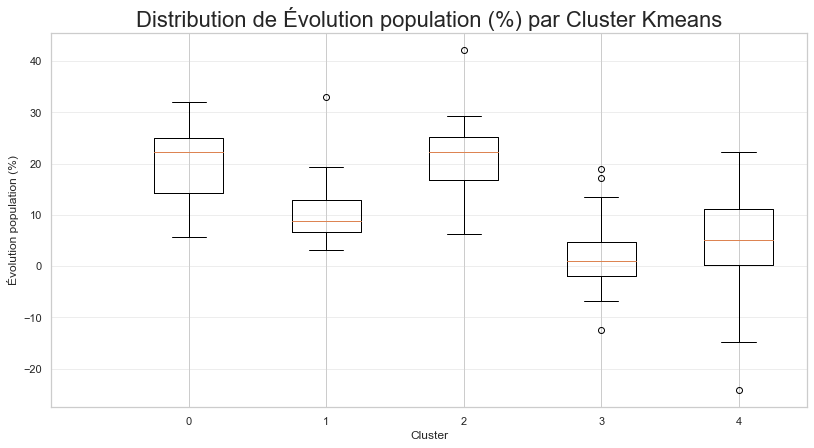

In [56]:
boxplot_cluster_km('Évolution population (%)')

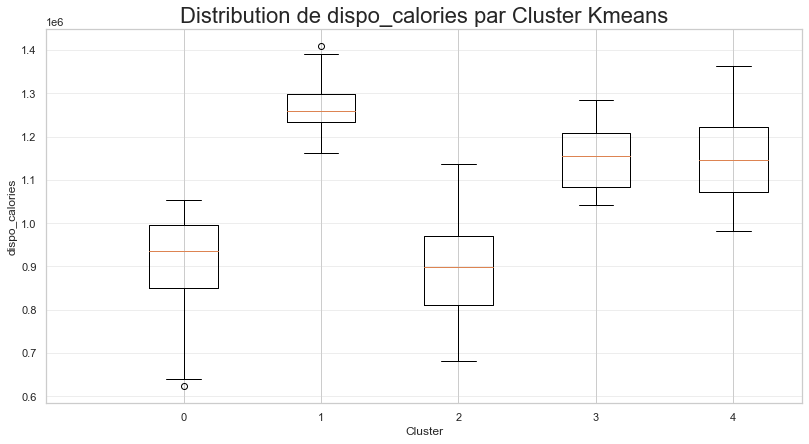

In [57]:
boxplot_cluster_km('dispo_calories')



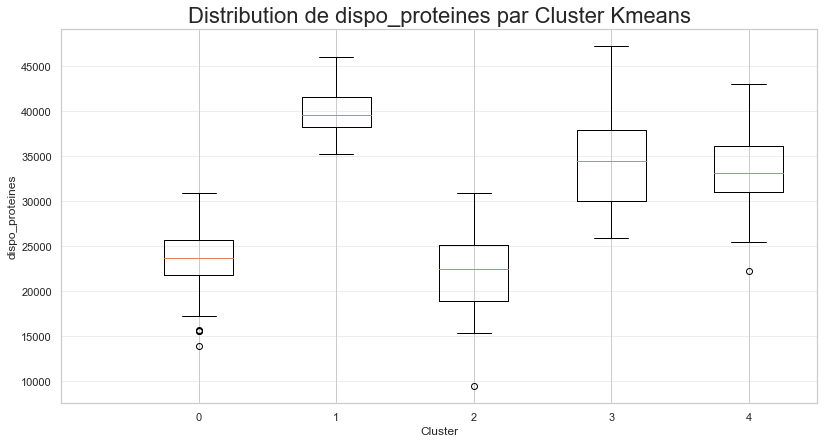

In [58]:
boxplot_cluster_km('dispo_proteines')


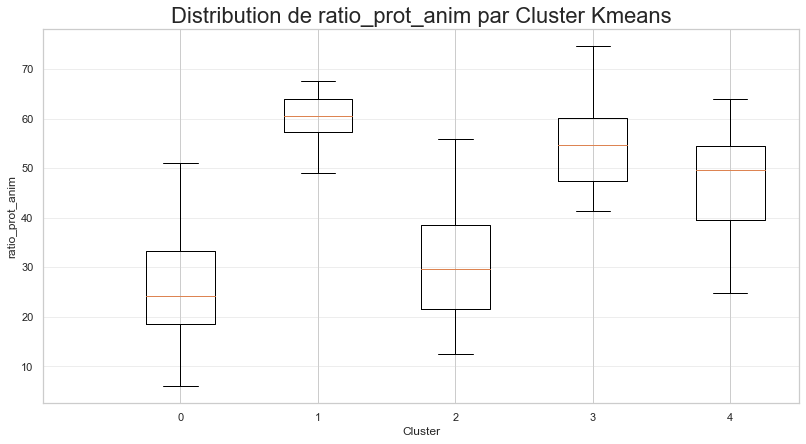

In [59]:
boxplot_cluster_km('ratio_prot_anim')


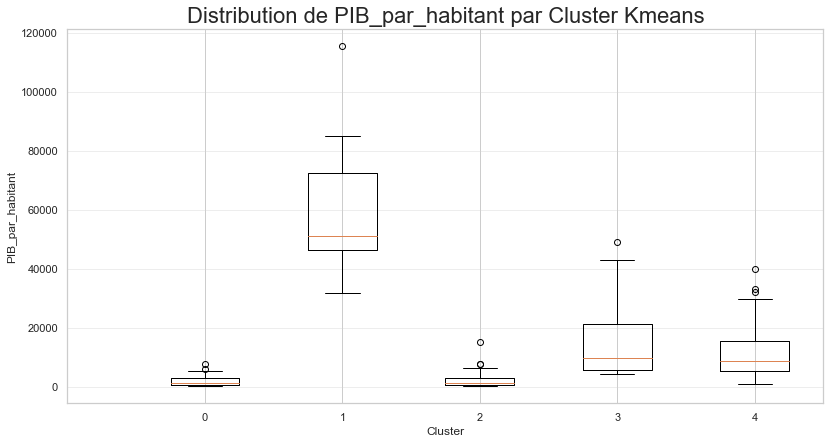

In [60]:
boxplot_cluster_km('PIB_par_habitant')


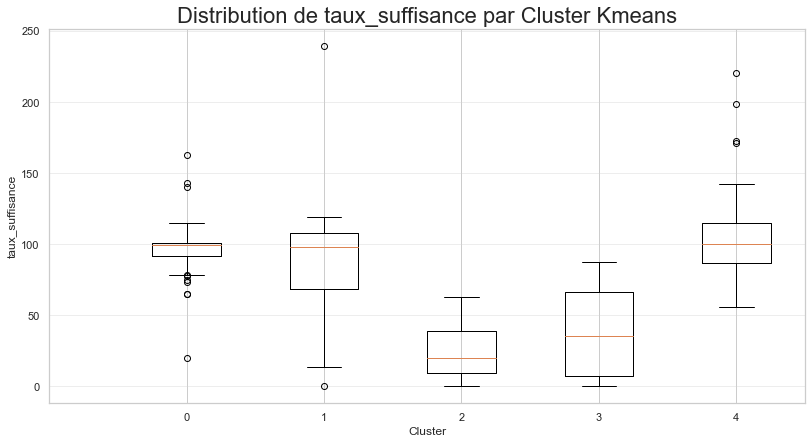

In [61]:
boxplot_cluster_km('taux_suffisance')


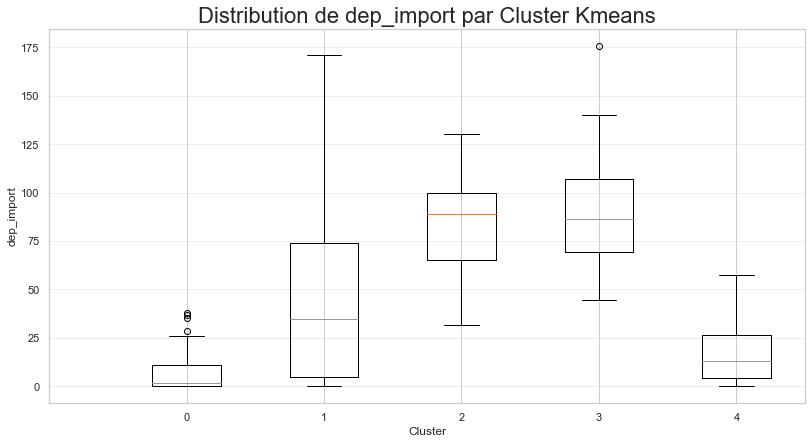

In [62]:
boxplot_cluster_km('dep_import')


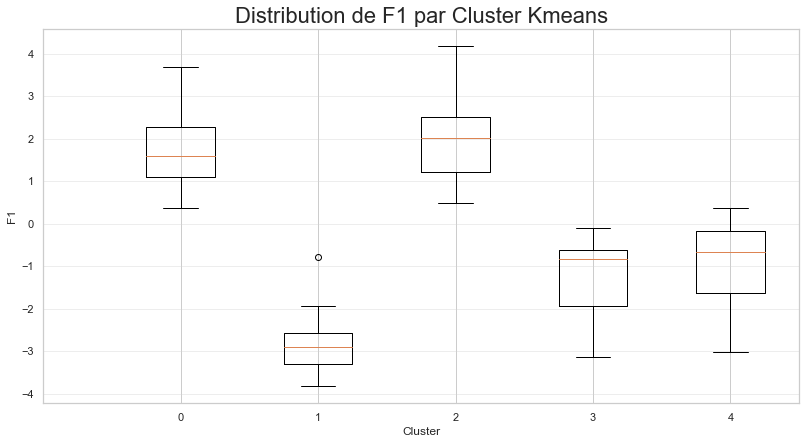

In [63]:
boxplot_cluster_km('F1')


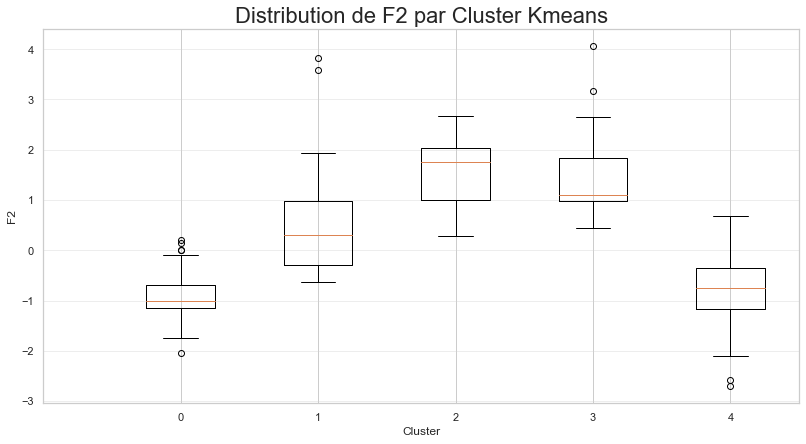

In [64]:
boxplot_cluster_km('F2')


# Sélections des pays sur groupes Kmeans.

Basé sur les mêmes critères qui ont été suivis lors de la sélection des pays par CAH (les groupes qui dépendent fortement des importations).
  et le PIB par habitant est beaucoup plus élevé), 
Les groupes de Kmeans à conserver sont ceux où F2 est supérieur à 1, soit les groupes 2, 3 et 4.
Nous constatons que les groupes 3 et 4 atteignent un niveau élevé de consommation de protéines animales et ont un PNB élevé,

In [73]:
select_clusters_kmeans = df_boxkm.groupby("groupe_km").mean().reset_index()
select_clusters_kmeans = df_boxkm[df_boxkm["F1"]<-1]["groupe_km"].unique()
select_clusters_kmeans

array([1, 3, 4], dtype=int32)

In [72]:
df_select_pays_kmeans = df_boxkm[df_boxkm["groupe_km"].isin(select_clusters_kmeans)]
df_select_pays_kmeans.to_csv('exports/Des groupe pays sur kmeans.csv', index=False)

df_select_pays_kmeans.pays.unique()

array(['Israël', 'Irlande', 'Nouvelle-Zélande', 'Chine - RAS de Macao',
       'Koweït', 'Norvège', 'Allemagne',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
       'Luxembourg', 'Belgique', 'Canada', 'Australie', 'Finlande',
       'Autriche', "États-Unis d'Amérique", 'Danemark', 'Suède', 'Suisse',
       'République centrafricaine', 'Cabo Verde', 'Yémen', 'Ghana',
       'République démocratique du Congo', 'Botswana', 'Angola',
       'Mauritanie', 'Afghanistan', 'Îles Salomon', 'Libéria', 'Congo',
       'Sierra Leone', 'Namibie', 'Gambie', 'Guinée', 'Gabon', 'Haïti',
       'Timor-Leste', 'Kirghizistan', 'Guinée-Bissau', 'Tadjikistan',
       'Iraq', 'Bénin', 'Oman', 'Papouasie-Nouvelle-Guinée', 'Suriname',
       'Lesotho', 'Slovaquie', 'Macédoine du Nord', 'Tchéquie',
       'Émirats arabes unis', 'Arménie', 'Mongolie', 'Albanie',
       'Bulgarie', 'Cuba', 'Estonie', 'Géorgie',
       'Chine - RAS de Hong-Kong', 'Kazakhstan', 'Monténégro', 'Lettonie'],
      dty

In [67]:
df_select_pays_kmeans.shape

(61, 12)

Ces groupes comptent 68 pays

Le Kmeans nous ont permis de faire une sélection plus fine des pays. Ce sera notre groupe cible de deuxième niveau
En premier niveau, nous choisirons les pays issus de l'niveau et de la CAH
En faisant une comparaison avec les groupes de CAH et en prenant les pays communs, on obtient 22 pays

In [68]:
df_compare_1 = pd.merge(df_select_pays_cah[['pays','groupe_cah']], df_select_pays_kmeans[['pays','groupe_km']],
                     on='pays', how='outer')
df_compare_1

,pays,groupe_cah,groupe_km
0,Australie,4.0,1.0
1,Autriche,4.0,1.0
2,Canada,4.0,1.0
3,Danemark,4.0,1.0
4,Finlande,4.0,1.0
...,...,...,...
59,Estonie,NaN,3.0
60,Géorgie,NaN,3.0
61,Kazakhstan,NaN,3.0
62,Monténégro,NaN,3.0


# Liste des pays et recommandations

In [69]:
df_select_pays_km_cah=df_compare_1.dropna()
df_select_pays_km_cah


,pays,groupe_cah,groupe_km
0,Australie,4.0,1.0
1,Autriche,4.0,1.0
2,Canada,4.0,1.0
3,Danemark,4.0,1.0
4,Finlande,4.0,1.0
5,Gabon,5.0,2.0
6,Allemagne,4.0,1.0
7,Chine - RAS de Hong-Kong,5.0,3.0
8,Irlande,4.0,1.0
9,Israël,4.0,1.0


In [70]:
df_select_pays_km_cah.shape

(23, 3)

Liste des pays et recommandations Dans un premier temps, on suggère donc de cibler les pays de l'UE, pour leur proximité et la facilité des échanges commerciaux : l'Allemagne, le Danemark, la Suède ,Luxembourg et le Norvège.

Prudence avec le Royaume-Uni, puisqu'avec le Brexit, les échanges commerciaux avec l'UE sont actuellement compliqués. Pour autant, considérant les intérêts économiques mutuels, les récentes directives qui ont été prises pour favoriser ces échanges sont en notre faveur.

De plus, il n'est pas préférable d'exporter vers l'Amérique et les Pays-Bas, car c'est l'un des pays les plus exportateurs de poulet au monde en plus du Brésil.

Dans un second temps, on pourrait également cibler les pays comme Hong Kong, le Japon, Émirats arabes unis, ainsi que le Koweït.

FAO - Poultry production - Marchés et commerce https://www.fao.org/poultry-production-products/aspects-socio-economiques/marches-et-commerce/fr/

"Le Brésil est le principal exportateur de viande de volaille, suivi par les États-Unis et les Pays-Bas. Les principaux pays importateurs sont la Chine, le Japon, le Mexique et le Royaume-Uni."

"Les pays les moins avancés sont de plus en plus dépendants des importations de viande de volaille. Le niveau de leurs importations est passé de 3 pour cent en 1961 à environ 30 pour cent en 2013."



https://www.fao.org/poultry-production-products/production/fr/

"Les États-Unis d'Amérique sont le plus grand producteur de viande de volaille à l’échelle de la planète: ils produisent en effet 17 pour cent de la production mondiale. Viennent ensuite la Chine et le Brésil."

"Pour répondre à la demande croissante, la production de viande de volaille mondiale a bondi, passant de 9 à 132 millions de tonnes entre 1961 et 2019."

"En 2019, la viande de volaille représentait environ 39 pour cent de la production mondiale de viande."

"Dans les pays en développement, environ 80 pour cent des ménages ruraux élèvent des volailles."

# Tests statistiques


Dans votre partition, vous avez obtenu des groupes distincts. Vérifiez donc qu'ils diffèrent réellement. Pour cela, réalisez les tests statistiques suivants :

un test d'adéquation : parmi les 4 variables, ou parmi d'autres variables que vous trouverez pertinentes, trouvez une variable dont la loi est normale ;
un test de comparaison de deux populations (dans le cas gaussien) : choisissez 2 clusters parmi ceux que vous aurez déterminé. Sur ces 2 clusters, testez la variable gaussienne grâce à un test de comparaison
## Nos groupes sont-ils réellement distincts?

On peut tester l’adéquation de la 'Disponibilité alimentaire de prot (g/personne/jour)' à une loi normale à l’aide de Kolmogorov-Smirnov. Le test sera doublé par celui de Shapiro-Wilk.

In [71]:
import scipy.stats as st
from scipy import stats
from scipy.stats import ks_2samp

### Test d'adéquation de Kolmogorov-Smirnov :

### Vérification des hypothèses

**H0 = La variable suit donc  une loi normale .**

**H1 = La variable ne suit pas une loi normale.**

In [72]:
df_groupes_cah.head(1)

,pays,Évolution population (%),dispo_calories,dispo_proteines,ratio_prot_anim,PIB_par_habitant,taux_suffisance,dep_import,groupe_cah,groupe_km
0,Arménie,2.35,1103030.0,34415.85,56.06,4622.733216,21.818182,78.181818,3,3


In [73]:
#Kolmogorov Smirnov test
stat, p= st.ks_2samp(df_groupes_cah['dispo_proteines'], 
            np.random.normal(df_groupes_cah['dispo_proteines'].mean(), 
                             df_groupes_cah['dispo_proteines'].std(ddof=0),
                             df_groupes_cah['dispo_proteines'].count()))

print('Statistics=%.3f, p=%.3f' % (stat, p))

#Interprétation
alpha = 0.05
if p > alpha:
    print(' Nous pouvons accepter H0 pour des niveaux de test de 5 %')
else:
    print('H0 est rejetée à un niveau de test de 5%')
    

Statistics=0.072, p=0.826
 Nous pouvons accepter H0 pour des niveaux de test de 5 %


### Test d'adéquation de Shapiro-Wilk :

*Recommandé pour tester la normalité dans le cas de petits échantillons.

In [74]:
#creation of the df with only clusters 4 & 5
c4c5 = df_groupes_cah[(df_groupes_cah['groupe_cah'] == 4) | (df_groupes_cah['groupe_cah'] == 5)]

In [75]:
#conda install -c conda-forge pingouin
#Pingouin is an open-source statistical package written in Python 3 and based mostly on Pandas and NumPy. 

**Test de Shapiro-Wilk** : teste si un échantillon suit une loi normale ou non (hypothèse nulle : suit une loi normale, donc si p-value < 0.01, l'échantillon ne suit pas une loi normale). Cela permet alors d'utiliser certains tests statistiques si la réponse est oui.

In [76]:
#normality of variables in c4c5
import pingouin as pg
pg.normality(c4c5, method='shapiro', alpha=0.05).drop('groupe_cah')

#normality: test de normalité univarié.

,W,pval,normal
Évolution population (%),0.877715,0.005153,False
dispo_calories,0.952844,0.270070,True
dispo_proteines,0.938989,0.127038,True
ratio_prot_anim,0.981259,0.899440,True
PIB_par_habitant,0.960414,0.399750,True
taux_suffisance,0.834285,0.000716,False
dep_import,0.898618,0.014584,False
groupe_km,0.668658,0.000002,False


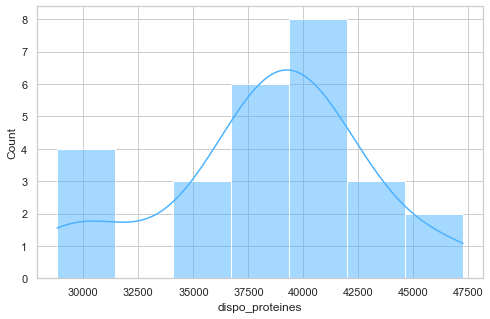

In [77]:
#histogram
sns.histplot(data=c4c5, x='dispo_proteines', kde=True, color='#4cb2ff')
plt.savefig("exports/tester la normalité dispo_proteines.jpg")

plt.show()

#### Disponibilité alimentaire énergétique


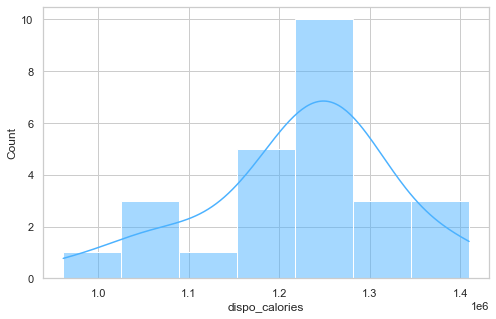

In [78]:
#histogram
sns.histplot(data=c4c5, x='dispo_calories', kde=True, color='#4cb2ff')
plt.savefig("exports/tester la normalité dispo_calories.jpg")
plt.show()

#### Importation de viande de volaille


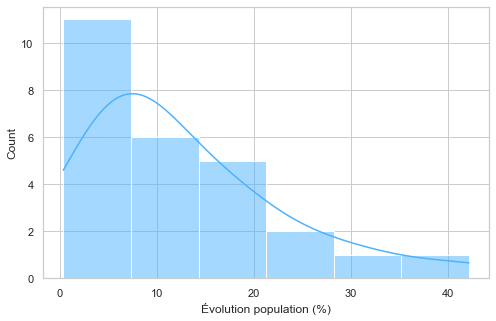

In [ ]:
#histogram
sns.histplot(data=c4c5, x='Évolution population (%)', kde=True, color='#4cb2ff')
plt.savefig("exports/tester la normalité Évolution populations.jpg")

plt.show()

#### Pourcentage de protéine animale


In [ ]:
#histogram
sns.histplot(data=c4c5, x='ratio_prot_anim', kde=True, color='#4cb2ff')
plt.savefig("exports/tester la normalité ratio_pro.jpg")

plt.show()

#### Produit Intérieur Brut


In [ ]:
#histogram
sns.histplot(data=c4c5, x='PIB_par_habitant', kde=True, color='#4cb2ff')
plt.savefig("exports/tester la normalité PIB.jpg")

plt.show()

#### Importation de viande de volaille


In [ ]:
#histogram
sns.histplot(data=c4c5, x='taux_suffisance', kde=True, color='#4cb2ff')
plt.savefig("exports/tester la normalité taux_suffisance.jpg")

plt.show()


In [ ]:
#histogram
sns.histplot(data=c4c5, x='dep_import', kde=True, color='#4cb2ff')
plt.savefig("exports/tester la normalité taux_dépendance_importations.jpg")

plt.show()

### Test de comparaison de deux clusters dans le cas gaussien.

Si on souhaite comparer deux échantillons (i.i.d) gaussiens, il nous suffit en fait de comparer leurs paramètres : leur moyenne μ1 et μ2, et leur variance σ21 et σ22.
La méthodologie la plus classique est d'effectuer de manière séquentielle :

Un test d'égalité des variances.

Un test d'égalité des moyennes.

Si les variances ne sont pas considérées comme égales, les deux échantillons n'ont pas la même loi. Si les variances sont considérées comme égales, il est alors possible d'estimer cette variance sur les deux échantillons à la fois, et de tester l'égalité des moyennes en utilisant cette variance empirique globale.
Notons qu'il est néanmoins possible d'effectuer un test de comparaison des moyennes sous hypothèse de variances différentes. Il ne s'agit pas d'une comparaison des lois, mais alors d'une comparaison simple des moyennes.



## La variable 'dispo_proteines' suit une loi normale et sera par conséquent choisie pour le test.



In [ ]:
#boxplot
color = sns.color_palette('pastel')

plt.figure(figsize=(30,15)) 

sns.boxplot(data=c4c5[(c4c5["groupe_cah"]== 4) | (c4c5["groupe_cah"]== 5)], x='dispo_proteines', y='groupe_cah', orient='h', palette=color,
            fliersize=4 , showfliers=True, showmeans=True, meanprops={"marker":"o", 
                                                                      "markerfacecolor":"white",
                                                                      "markeredgecolor":"white", 
                                                                      "markersize":"10"})

plt.xlabel('Dispo alim en protéine', fontsize=20, labelpad=30, fontweight='bold')
plt.xticks(fontsize=20)
plt.ylabel('Cluster', fontsize=20, labelpad=30, fontweight='bold')
plt.yticks(fontsize=20)
plt.title('Disponibilité alimentaire en protéine pour les cluster 4 et 5', fontsize=35, pad=50)
plt.savefig("exports/Disponibilité alimentaire en protéine pour les cluster 4 et 5.jpg")


plt.show()

### Tester l'égalité de la variance

**H0 = Les variance sont égales .**

**H1 = Les variance ne sont pas égales.** 

In [ ]:
#On teste tout d’abord l’égalité des variances à l’aide de la commande
pg.homoscedasticity(df_groupes_cah, dv='dispo_proteines',  group='groupe_cah', method='levene', 
                    alpha=0.05)
#Thomoscedasticity :tester l'égalité de la variance.

### Tester l'égalité des moyennes

**H0 = Les moyennes sont égales .**

**H1 = Les moyennes ne sont pas égales.** 

In [ ]:
#On teste ensuite l’égalité des moyennes à l’aide de la commande
pg.ttest(df_groupes_cah['dispo_proteines'][df_groupes_cah['groupe_cah'] == 4],
         df_groupes_cah['dispo_proteines'][df_groupes_cah['groupe_cah'] == 5],
         paired=False,
        
         confidence=0.95)

In [ ]:
α = 0.05

if α > pg.ttest(df_groupes_cah['dispo_proteines'][df_groupes_cah['groupe_cah'] == 4],
             df_groupes_cah['dispo_proteines'][df_groupes_cah['groupe_cah'] == 5]).iloc[0,3] : 
    
    print("La p-value étant inférieure au risque α, on rejette donc H0, les moyennes des deux groupes sont différentes.")
else :
    print("La p-value étant supérieur au risque α, H0 est donc vrai, les moyennes des deux groupes sont égales.")